In [57]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#sklearn
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.inspection import permutation_importance

from sklearn.neighbors import KNeighborsClassifier

#json
import json

<h3>Functions</h3>

In [24]:
def plot_grid_search_results(grid_results, grid_best_params, grid_best_score):
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (12,18)) #figsize = (13,30)
    
    ax1.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_f1'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_f1'],
                 ecolor = 'orange')
    ax1.set_xlabel('n_neigbors')
    ax1.set_ylabel('f1')
    ax1.set_title('Classification F1')
    
    ax2.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_recall'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_recall'],
                 ecolor = 'orange')
    ax2.set_xlabel('n_neigbors') 
    ax2.set_ylabel('recall')
    ax2.set_title('Classification Recall')
    
    ax3.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_roc_auc'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_roc_auc'],
                 ecolor = 'orange')
    ax3.plot([grid_best_params['n_neighbors']], [grid_best_score], 
              marker='.', 
              markeredgewidth=3,
              c='r')
    ax3.annotate('best k', xy = (grid_best_params['n_neighbors'], grid_best_score),
                 xytext = (grid_best_params['n_neighbors'] + 1, grid_best_score + 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.01))
    ax3.set_xlabel('n_neigbors') 
    ax3.set_ylabel('roc auc')
    ax3.set_title('Classification Roc Auc')

    fig.tight_layout()
    plt.show()

In [25]:
def results_permutation_importance(res, attr):
    
    # get importance
    importance = res.importances_mean
    
    # summarize feature importance
    feature_importances = []
    for col, imp in zip(attr, importance):
        feature_importances.append((col, imp))
  
    sorted_feature_importances = sorted(feature_importances, key=lambda tup:(-tup[1], tup[0]))
    
    return sorted_feature_importances

In [26]:
def plot_permutation_importance(res, attr, tit):
    
    fig, ax = plt.subplots(figsize = (12,8)) 
    
    feature_names = np.r_[attr]
    
    importance = res.importances_mean
    sorted_idx = res.importances_mean.argsort()
    
    y_ticks = np.arange(0, len(feature_names))
    ax.barh(y_ticks, importance[sorted_idx], height=0.7, color = "#CC6600")
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title(tit)
    
    fig.tight_layout()
    plt.show()

In [27]:
def draw_confusion_matrix(Clf, X, y):
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(Clf, X, y,
                                 cmap='OrRd',
                                 normalize=normalize)
        disp.ax_.set_title(title)
    
    plt.show()

In [28]:
def draw_roc_curve(Y_test, Y_pred, diz, k):
    
    fig, ax = plt.subplots() #figsize = (13,30)
    
    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred, average = None)
    
    diz[k] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc": roc_auc}
    
    ax.plot(fpr, tpr, color = "#994D00", label='ROC curve (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.set_title('Roc curve of the model')
    ax.tick_params(axis='both')
    ax.legend(loc="lower right", fontsize=14, frameon=False)
    
    fig.tight_layout()
    plt.show()

In [29]:
df = pd.read_csv("Numerical_NON_NORMALIZED_Train_HR_Employee_Attrition.csv")

In [30]:
df

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,0,1,0,9,4,2,0,3,...,17,3,0,2,2,8,7,156.61,0.39,2
1,36,0,0,1,0,1,1,2,0,3,...,14,3,1,3,3,1,8,157.94,0.41,2
2,25,0,0,0,1,16,3,3,0,3,...,25,3,1,4,3,1,5,448.06,0.70,3
3,33,0,0,1,0,5,4,2,0,3,...,14,2,0,1,3,3,7,271.91,0.84,2
4,31,0,0,1,0,9,2,3,1,3,...,12,3,0,2,3,10,2,106.37,0.21,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,38,1,0,1,0,12,3,3,1,4,...,15,4,0,2,3,10,0,282.47,0.79,3
879,37,0,0,1,0,16,2,4,1,4,...,13,2,2,3,2,17,0,76.29,0.71,3
880,33,1,1,0,0,6,4,2,1,1,...,18,2,0,2,2,11,7,272.88,0.75,2
881,33,0,0,1,0,4,1,3,0,2,...,12,1,0,2,4,3,2,208.67,0.86,2


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     883 non-null    int64  
 1   Attrition                               883 non-null    int64  
 2   BusinessTravel_Non-Travel               883 non-null    int64  
 3   BusinessTravel_Travel_Rarely            883 non-null    int64  
 4   BusinessTravel_Travel_Frequently        883 non-null    int64  
 5   DistanceFromHome                        883 non-null    int64  
 6   Education                               883 non-null    int64  
 7   EnvironmentSatisfaction                 883 non-null    int64  
 8   Gender                                  883 non-null    int64  
 9   JobInvolvement                          883 non-null    int64  
 10  JobLevel                                883 non-null    int64 

In [32]:
df.describe()

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,...,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,36.554926,0.173273,0.101925,0.733862,0.164213,9.201586,2.886750,2.684032,0.388448,2.750849,...,15.207248,2.716874,0.793884,2.665912,2.767837,6.326161,3.919592,234.245832,0.463918,2.322763
std,8.266129,0.378698,0.302721,0.442188,0.370679,8.241818,1.008285,1.092567,0.487674,0.729354,...,3.589332,1.078137,0.865362,1.187828,0.721713,4.523567,3.435392,130.196652,0.319880,0.535595
min,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,26.040000,0.000000,1.000000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,...,12.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,130.630000,0.130000,2.000000
50%,35.000000,0.000000,0.000000,1.000000,0.000000,7.000000,3.000000,3.000000,0.000000,3.000000,...,14.000000,3.000000,1.000000,2.000000,3.000000,5.000000,3.000000,212.280000,0.530000,2.000000
75%,42.000000,0.000000,0.000000,1.000000,0.000000,14.000000,4.000000,4.000000,1.000000,3.000000,...,18.000000,4.000000,1.000000,3.000000,3.000000,9.000000,7.000000,309.905000,0.760000,3.000000
max,60.000000,1.000000,1.000000,1.000000,1.000000,29.000000,5.000000,4.000000,1.000000,4.000000,...,25.000000,4.000000,3.000000,6.000000,4.000000,20.000000,16.000000,590.980000,0.950000,4.000000


<h3>Feature selection</h3>

In [33]:
features_sel = [col for col in df.columns if col != 'Attrition']

X_features_sel = df[features_sel].values
y_features_sel = df['Attrition']

OverTime                                           0.029467
JobSatisfaction                                    0.011190
JobRole_Sales_Representative                       0.009467
JobRole_Manufacturing_Director                     0.009153
JobRole_Laboratory_Technician                      0.008194
StockOptionLevel                                   0.007786
WorkLifeBalance                                    0.004889
JobInvolvement                                     0.004558
JobRole_Research_Scientist                         0.004122
JobRole_Sales_Executive                            0.003918
TrainingTimesLastYear                              0.003761
NumCompaniesWorked                                 0.003479
EnvironmentSatisfaction                            0.003316
YearsInCurrentRole                                 0.003097
JobRole_Healthcare_Representative                  0.002848
RelationshipSatisfaction                           0.002780
Age                                     

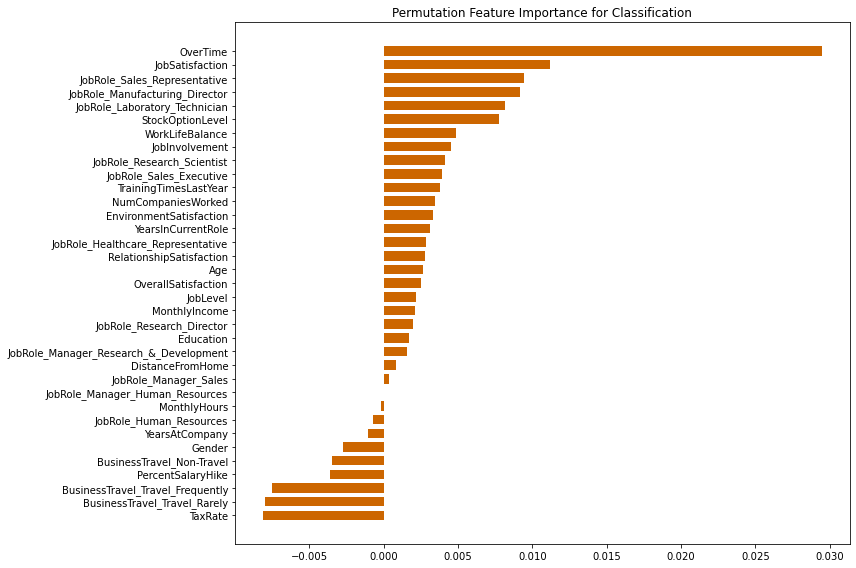

In [34]:
scaler_prova = MinMaxScaler()
X_features_sel_normalized = scaler_prova.fit_transform(X_features_sel)

model = KNeighborsClassifier()

model.fit(X_features_sel_normalized, y_features_sel)

results_features_sel = permutation_importance(model, X_features_sel_normalized, y_features_sel, scoring='roc_auc', n_repeats = 10)

sorted_feat_imp = results_permutation_importance(results_features_sel, features_sel)

#print results
for t in sorted_feat_imp:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
#plot results
t = 'Permutation Feature Importance for Classification'
plot_permutation_importance(results_features_sel, features_sel, t)

In [35]:
df = df.drop(['YearsInCurrentRole','JobRole_Manager_Sales',
              'JobRole_Manager_Human_Resources', 'JobRole_Sales_Executive',
              'JobRole_Human_Resources','YearsAtCompany', 'MonthlyIncome','MonthlyHours',
              'Education','Gender','BusinessTravel_Non-Travel',
              'PercentSalaryHike','BusinessTravel_Travel_Frequently',
              'BusinessTravel_Travel_Rarely','TaxRate', 'JobRole_Healthcare_Representative'], axis = 1)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   Age                                     883 non-null    int64
 1   Attrition                               883 non-null    int64
 2   DistanceFromHome                        883 non-null    int64
 3   EnvironmentSatisfaction                 883 non-null    int64
 4   JobInvolvement                          883 non-null    int64
 5   JobLevel                                883 non-null    int64
 6   JobRole_Laboratory_Technician           883 non-null    int64
 7   JobRole_Manager_Research_&_Development  883 non-null    int64
 8   JobRole_Manufacturing_Director          883 non-null    int64
 9   JobRole_Research_Director               883 non-null    int64
 10  JobRole_Research_Scientist              883 non-null    int64
 11  JobRole_Sales_Repre

<h3>Discretization</h3>

Continuous features to discretize:
- <b>Age</b>
- <b>DistanceFromHome</b>
- <b>YearsAtCompany</b>
- <b>YearsInCurrentRole</b>
- <b>NumCompaniesWorked</b>
- <b>MonthlyIncome</b>
- <b>MonthlyHours</b>
- <b>PercentSalaryHike</b>

In [37]:
columns_to_discretize = ['Age','DistanceFromHome','YearsAtCompany','YearsInCurrentRole',
'NumCompaniesWorked','MonthlyIncome','MonthlyHours','PercentSalaryHike']

In [38]:
df.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole_Laboratory_Technician,JobRole_Manager_Research_&_Development,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Representative,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,52,0,9,2,3,3,0,0,0,1,0,0,3,9,0,3,0,2,2,2
1,36,0,1,2,3,5,0,1,0,0,0,0,3,1,1,3,1,3,3,2
2,25,0,16,3,3,2,0,0,0,0,0,0,4,1,1,3,1,4,3,3
3,33,0,5,2,3,1,0,0,0,0,1,0,2,2,0,2,0,1,3,2
4,31,0,9,3,3,1,1,0,0,0,0,0,4,1,0,3,0,2,3,3


In [39]:
for column in columns_to_discretize:
    if column in df:
        df[column] = pd.qcut(df[column], q=4, duplicates='drop', labels=False)

In [40]:
df.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole_Laboratory_Technician,JobRole_Manager_Research_&_Development,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Representative,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,3,0,2,2,3,3,0,0,0,1,0,0,3,3,0,3,0,2,2,2
1,2,0,0,2,3,5,0,1,0,0,0,0,3,0,1,3,1,3,3,2
2,0,0,3,3,3,2,0,0,0,0,0,0,4,0,1,3,1,4,3,3
3,1,0,1,2,3,1,0,0,0,0,1,0,2,1,0,2,0,1,3,2
4,1,0,2,3,3,1,1,0,0,0,0,0,4,0,0,3,0,2,3,3


<h3>Divide into features and target</h3>

In [41]:
attributes = [col for col in df.columns if col != 'Attrition']

X = df[attributes].values
y = df['Attrition']

<h3>Stratified Holdout combined with Stratified K-fold Cross Validation</h3>

In [42]:
scaler_dict = dict()

<h4>MinMaxScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6595659426333539
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


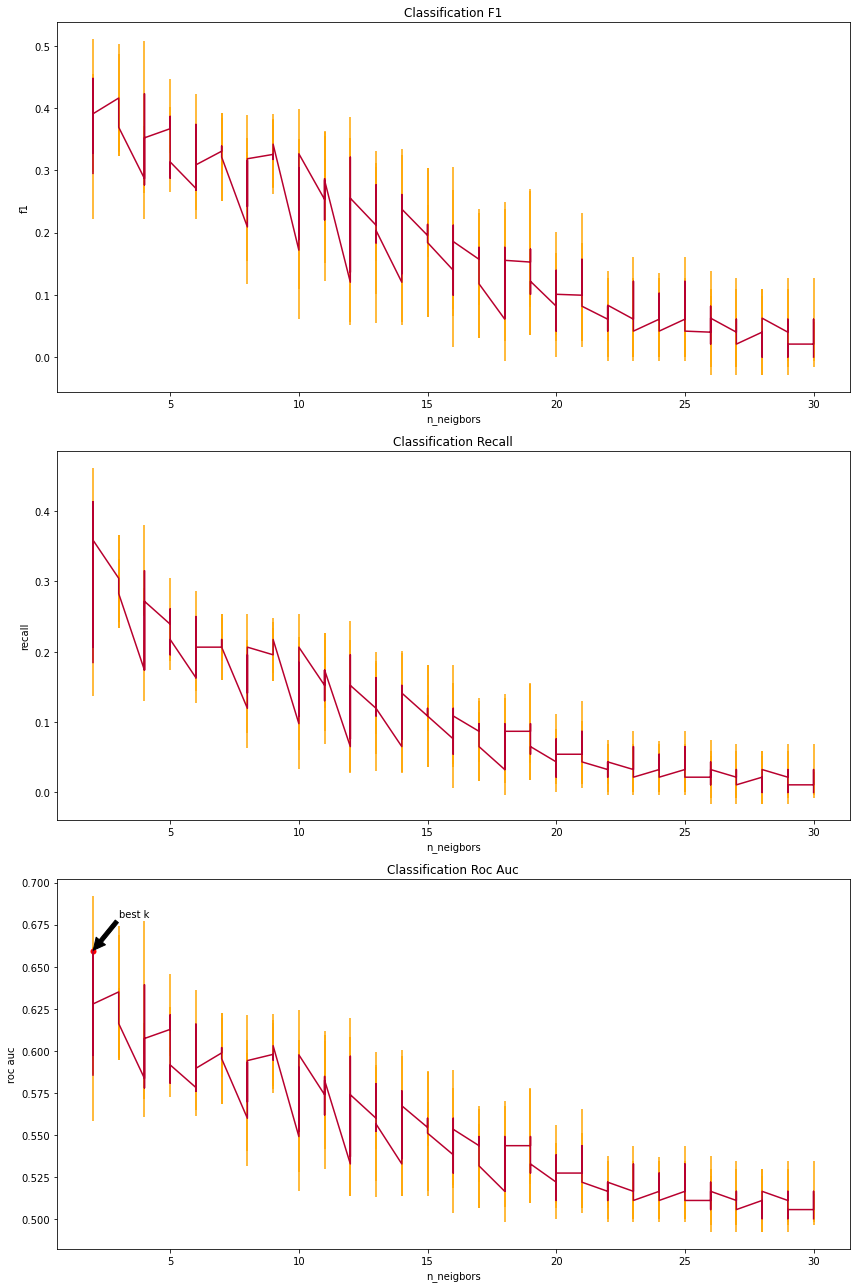



Permutation importances of the training set

JobSatisfaction                                    0.001811
OverTime                                           0.000312
NumCompaniesWorked                                 0.000174
DistanceFromHome                                   0.000034
JobRole_Research_Scientist                         0.000027
StockOptionLevel                                   0.000017
RelationshipSatisfaction                           0.000015
JobRole_Laboratory_Technician                      0.000015
JobInvolvement                                     0.000014
Age                                                0.000007
EnvironmentSatisfaction                            0.000004
TrainingTimesLastYear                              0.000002
JobLevel                                           0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.000000
JobRole_Research_Director                          0.

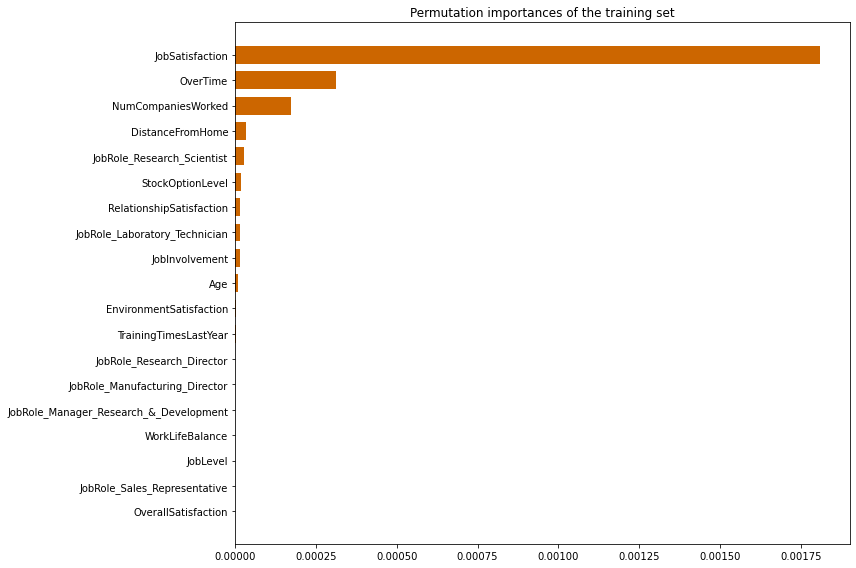



Predictions

Permutation importances of the test set

OverTime                                           0.040900
WorkLifeBalance                                    0.039641
NumCompaniesWorked                                 0.029617
Age                                                0.027970
JobRole_Sales_Representative                       0.024627
StockOptionLevel                                   0.022721
JobLevel                                           0.013680
JobRole_Laboratory_Technician                      0.008927
TrainingTimesLastYear                              0.005013
DistanceFromHome                                   0.004952
JobSatisfaction                                    0.004040
OverallSatisfaction                                0.003564
EnvironmentSatisfaction                            0.003427
JobRole_Manufacturing_Director                     0.001886
RelationshipSatisfaction                           0.000428
JobRole_Research_Director                   

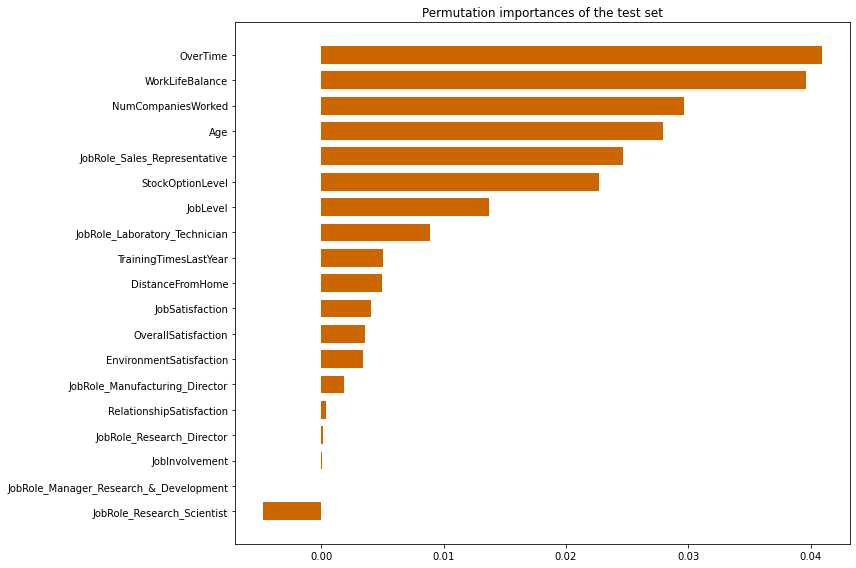



Confusion matrix


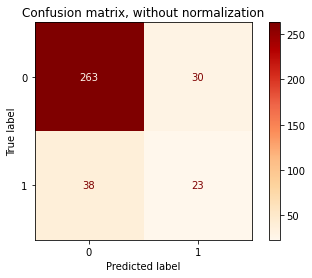

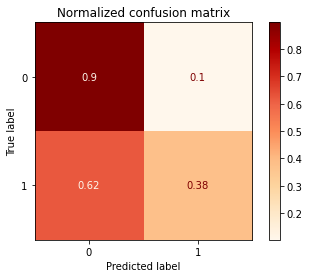


Classification report
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       293
           1       0.43      0.38      0.40        61

    accuracy                           0.81       354
   macro avg       0.65      0.64      0.64       354
weighted avg       0.80      0.81      0.80       354


Metrics

Accuracy 0.807909604519774
F1-score [0.88552189 0.40350877]
Precision [0.87375415 0.43396226]
Recall [0.89761092 0.37704918]
Roc_auc 0.6373300509147877


Roc curve



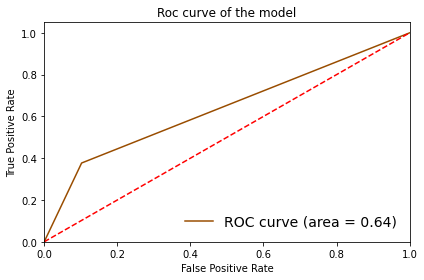


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.6173904493909416
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


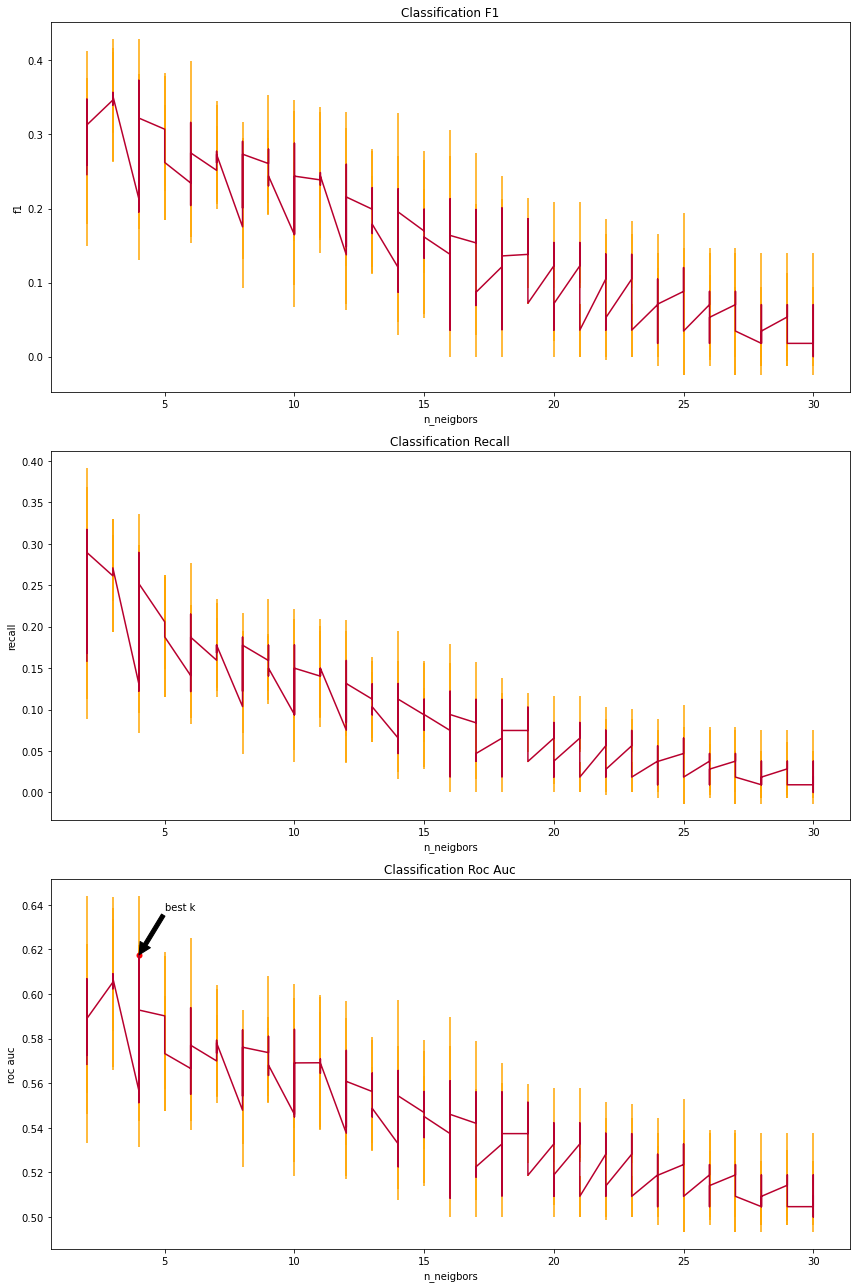



Permutation importances of the training set

OverTime                                           0.007209
JobRole_Laboratory_Technician                      0.002685
NumCompaniesWorked                                 0.002356
DistanceFromHome                                   0.001997
RelationshipSatisfaction                           0.000990
Age                                                0.000744
JobSatisfaction                                    0.000644
EnvironmentSatisfaction                            0.000640
StockOptionLevel                                   0.000622
JobRole_Research_Scientist                         0.000455
JobRole_Sales_Representative                       0.000218
JobRole_Manufacturing_Director                     0.000179
JobInvolvement                                     0.000172
WorkLifeBalance                                    0.000137
JobRole_Research_Director                          0.000007
JobRole_Manager_Research_&_Development             0.

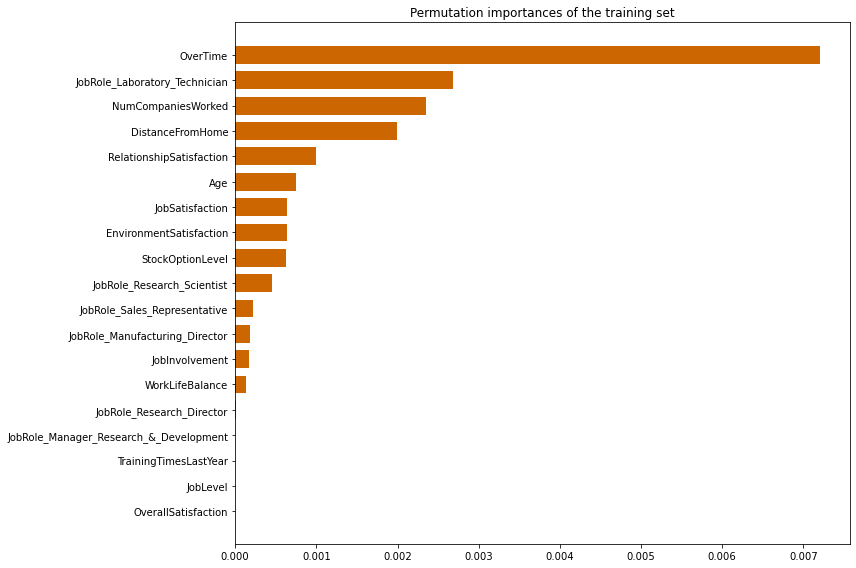



Predictions

Permutation importances of the test set

OverTime                                           0.088336
Age                                                0.045672
JobInvolvement                                     0.045608
StockOptionLevel                                   0.031904
WorkLifeBalance                                    0.030058
OverallSatisfaction                                0.028440
JobRole_Sales_Representative                       0.026405
DistanceFromHome                                   0.026117
JobLevel                                           0.021397
EnvironmentSatisfaction                            0.019843
JobSatisfaction                                    0.016989
NumCompaniesWorked                                 0.014324
JobRole_Research_Scientist                         0.007961
TrainingTimesLastYear                              0.005872
RelationshipSatisfaction                           0.005355
JobRole_Research_Director                   

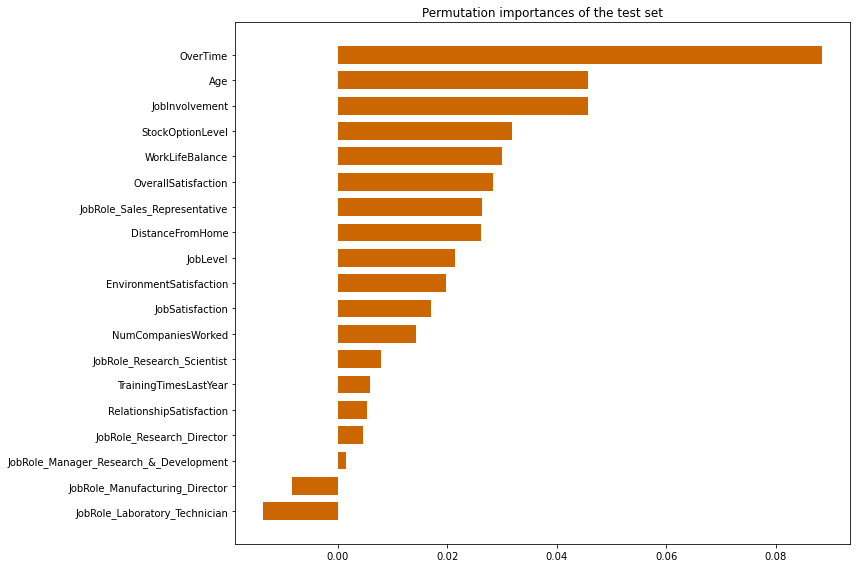



Confusion matrix


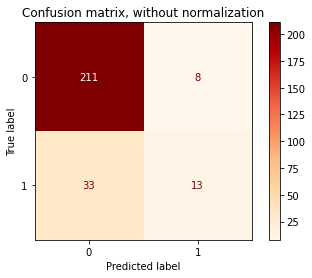

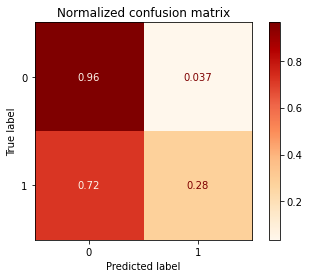


Classification report
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       219
           1       0.62      0.28      0.39        46

    accuracy                           0.85       265
   macro avg       0.74      0.62      0.65       265
weighted avg       0.82      0.85      0.82       265


Metrics

Accuracy 0.8452830188679246
F1-score [0.91144708 0.3880597 ]
Precision [0.8647541  0.61904762]
Recall [0.96347032 0.2826087 ]
Roc_auc 0.6230395076434385


Roc curve



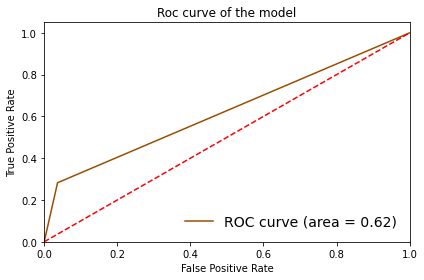


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6510145087641774
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


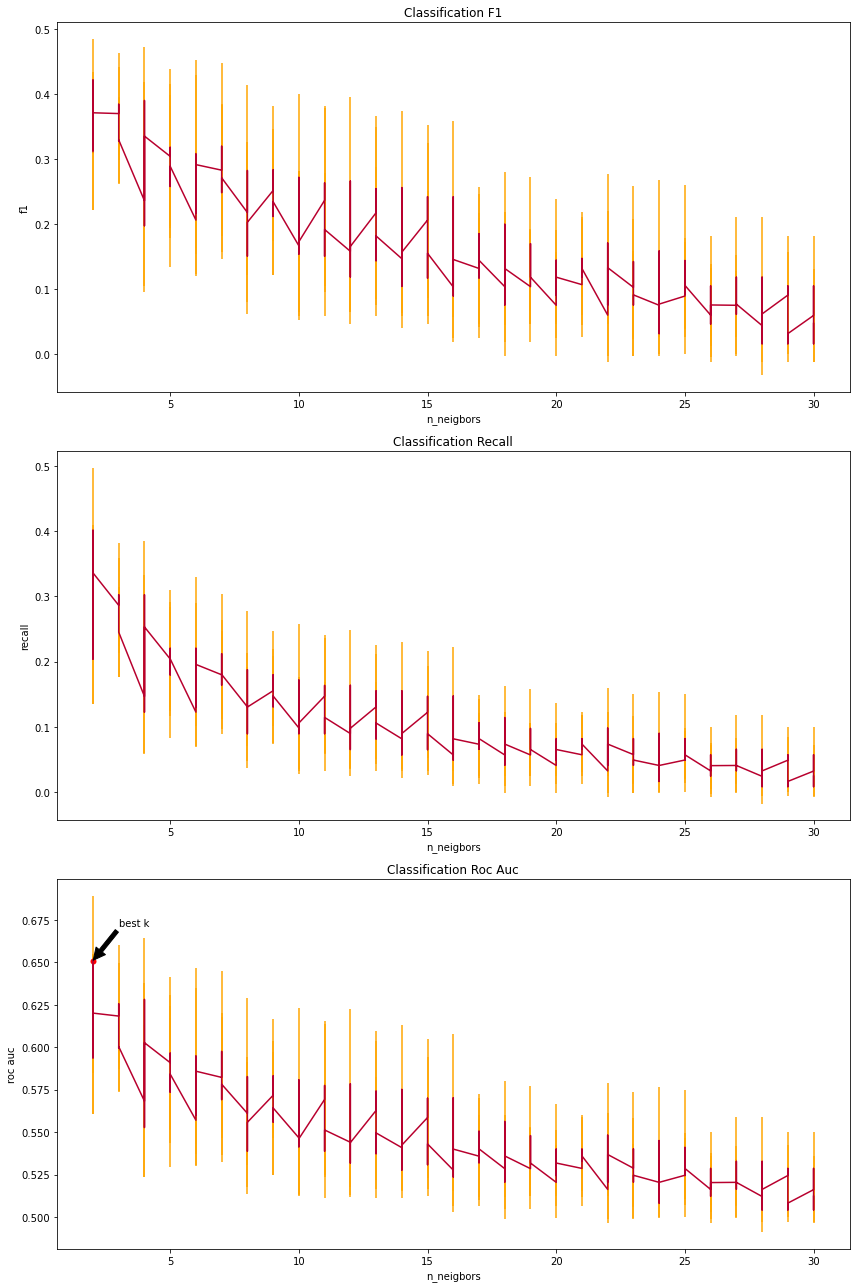



Permutation importances of the training set

NumCompaniesWorked                                 0.002001
JobSatisfaction                                    0.001378
OverTime                                           0.000449
EnvironmentSatisfaction                            0.000063
JobRole_Research_Scientist                         0.000062
StockOptionLevel                                   0.000043
Age                                                0.000029
JobRole_Laboratory_Technician                      0.000027
RelationshipSatisfaction                           0.000023
JobRole_Sales_Representative                       0.000020
DistanceFromHome                                   0.000019
TrainingTimesLastYear                              0.000007
JobInvolvement                                     0.000001
JobLevel                                           0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.

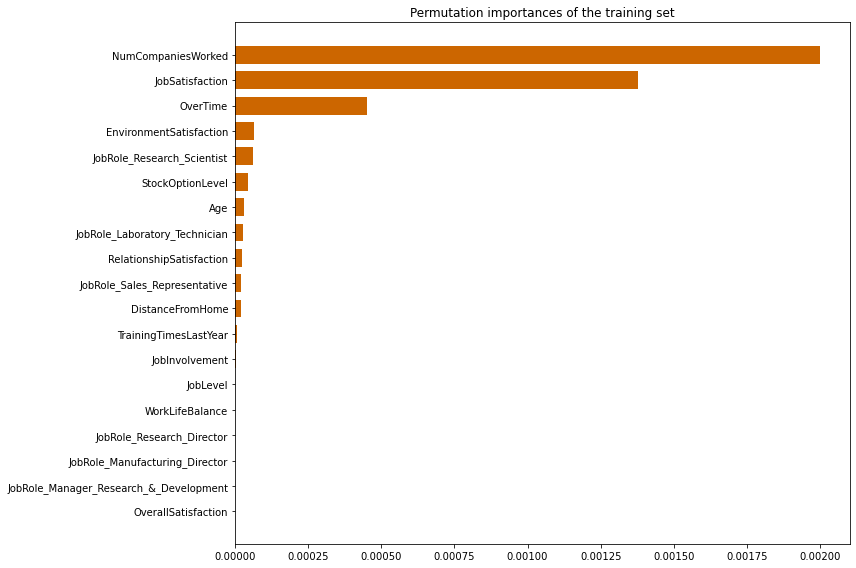



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.055281
OverTime                                           0.054110
JobSatisfaction                                    0.034401
JobRole_Sales_Representative                       0.032733
NumCompaniesWorked                                 0.025497
JobInvolvement                                     0.023575
Age                                                0.018228
TrainingTimesLastYear                              0.011600
JobRole_Research_Director                          0.008727
WorkLifeBalance                                    0.008573
OverallSatisfaction                                0.007567
JobRole_Manufacturing_Director                     0.006496
JobLevel                                           0.005391
JobRole_Research_Scientist                         0.005270
DistanceFromHome                                   0.003038
EnvironmentSatisfaction                     

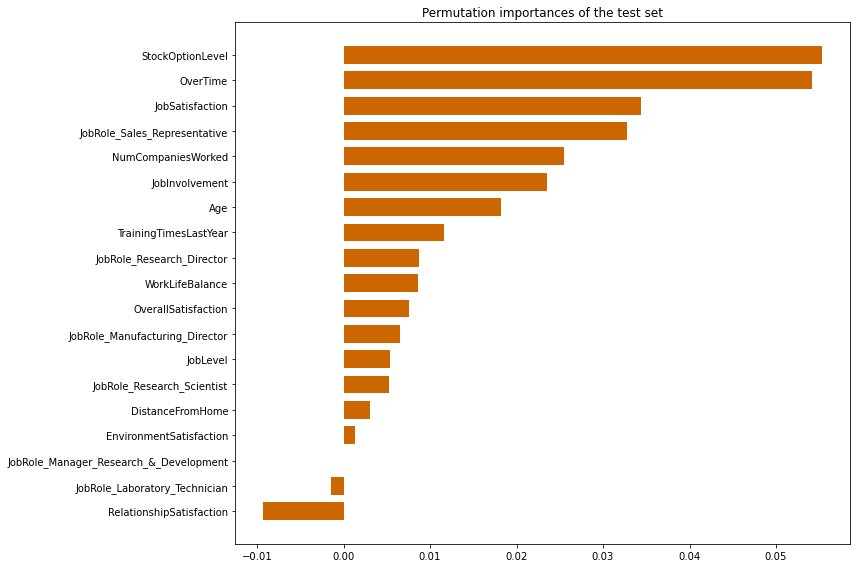



Confusion matrix


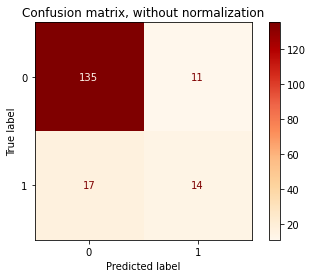

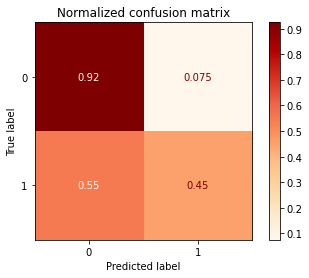


Classification report
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       146
           1       0.56      0.45      0.50        31

    accuracy                           0.84       177
   macro avg       0.72      0.69      0.70       177
weighted avg       0.83      0.84      0.83       177


Metrics

Accuracy 0.8418079096045198
F1-score [0.90604027 0.5       ]
Precision [0.88815789 0.56      ]
Recall [0.92465753 0.4516129 ]
Roc_auc 0.6881352187361909


Roc curve



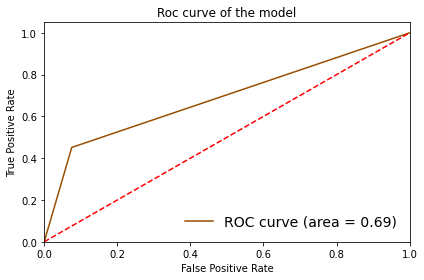


-------------------------------------------------------------------------------------------------------------



In [44]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
min_max_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MinMaxScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, min_max_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = min_max_dict

<h4>MaxAbsScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6627175726148603
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


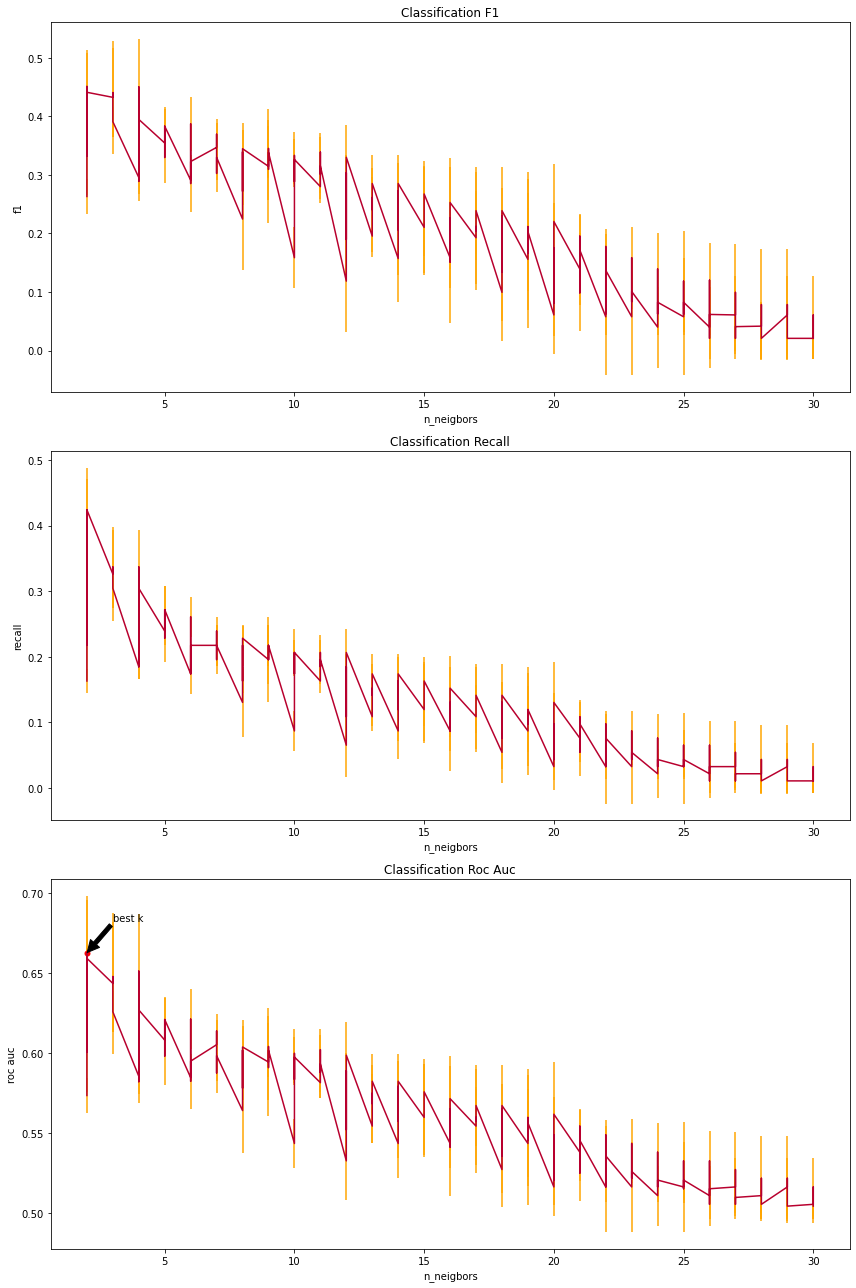



Permutation importances of the training set

NumCompaniesWorked                                 0.004145
DistanceFromHome                                   0.001295
OverTime                                           0.000976
JobRole_Research_Scientist                         0.000326
StockOptionLevel                                   0.000096
Age                                                0.000076
JobRole_Laboratory_Technician                      0.000067
JobSatisfaction                                    0.000017
JobRole_Sales_Representative                       0.000007
TrainingTimesLastYear                              0.000002
EnvironmentSatisfaction                            0.000001
RelationshipSatisfaction                           0.000001
JobInvolvement                                     0.000000
JobRole_Manufacturing_Director                     0.000000
JobLevel                                           0.000000
JobRole_Manager_Research_&_Development             0.

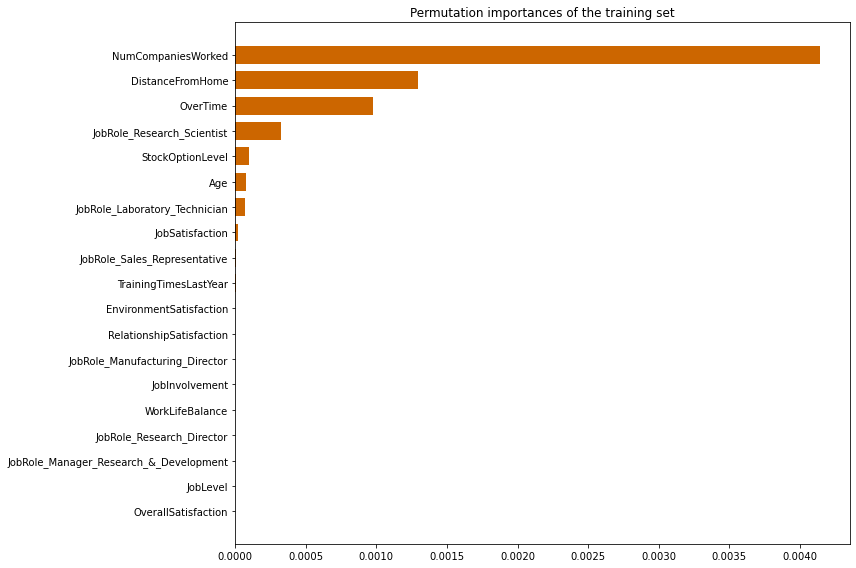



Predictions

Permutation importances of the test set

OverTime                                           0.053777
Age                                                0.044341
StockOptionLevel                                   0.030454
JobInvolvement                                     0.030138
WorkLifeBalance                                    0.024668
JobSatisfaction                                    0.016992
OverallSatisfaction                                0.016433
JobRole_Sales_Representative                       0.014838
JobRole_Laboratory_Technician                      0.012720
RelationshipSatisfaction                           0.010242
TrainingTimesLastYear                              0.005889
NumCompaniesWorked                                 0.004610
EnvironmentSatisfaction                            0.002529
DistanceFromHome                                   0.001983
JobRole_Research_Director                          0.001930
JobLevel                                    

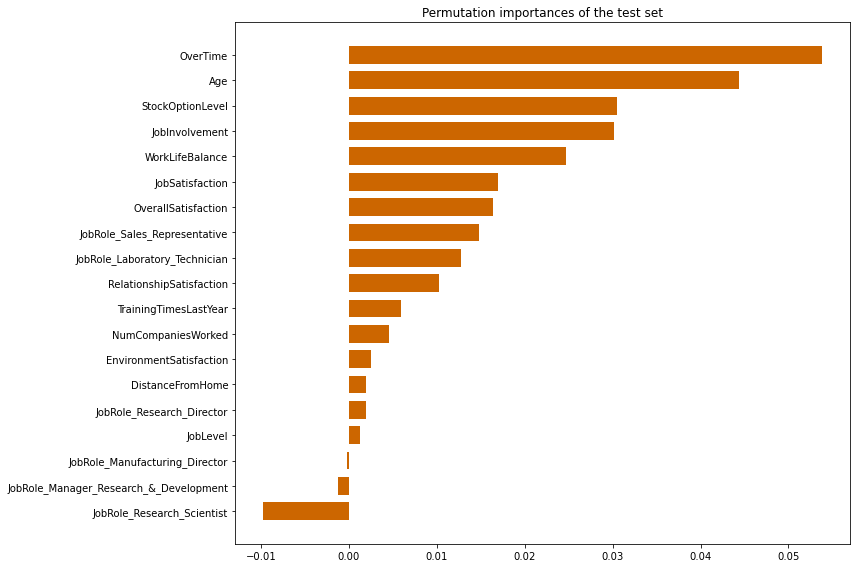



Confusion matrix


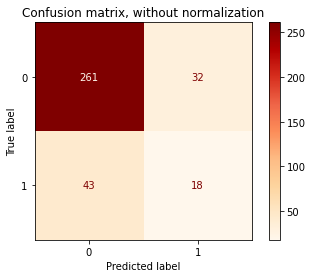

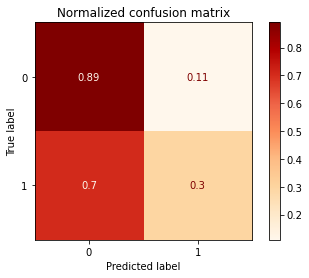


Classification report
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       293
           1       0.36      0.30      0.32        61

    accuracy                           0.79       354
   macro avg       0.61      0.59      0.60       354
weighted avg       0.77      0.79      0.78       354


Metrics

Accuracy 0.788135593220339
F1-score [0.87437186 0.32432432]
Precision [0.85855263 0.36      ]
Recall [0.89078498 0.29508197]
Roc_auc 0.5929334750741342


Roc curve



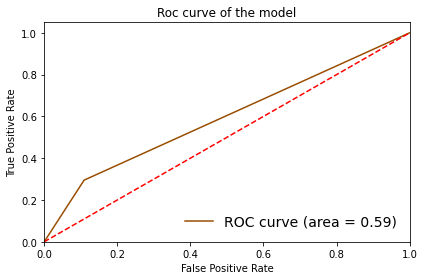


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.6183516329539337
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


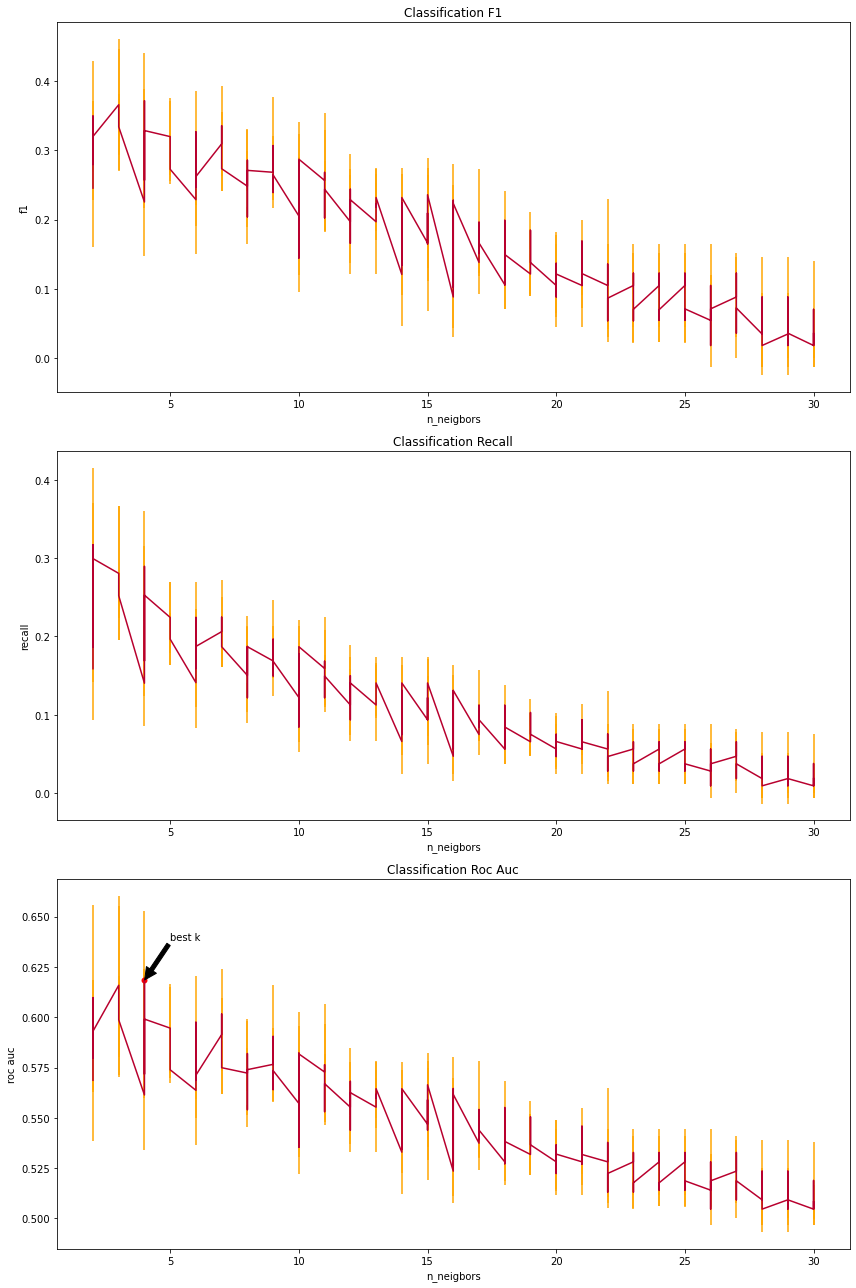



Permutation importances of the training set

OverTime                                           0.011725
NumCompaniesWorked                                 0.003687
JobRole_Laboratory_Technician                      0.003493
DistanceFromHome                                   0.002906
Age                                                0.001619
JobRole_Research_Scientist                         0.001299
StockOptionLevel                                   0.000821
RelationshipSatisfaction                           0.000591
JobRole_Sales_Representative                       0.000529
JobRole_Manufacturing_Director                     0.000501
JobSatisfaction                                    0.000430
EnvironmentSatisfaction                            0.000351
JobInvolvement                                     0.000051
WorkLifeBalance                                    0.000040
JobRole_Research_Director                          0.000013
TrainingTimesLastYear                              0.

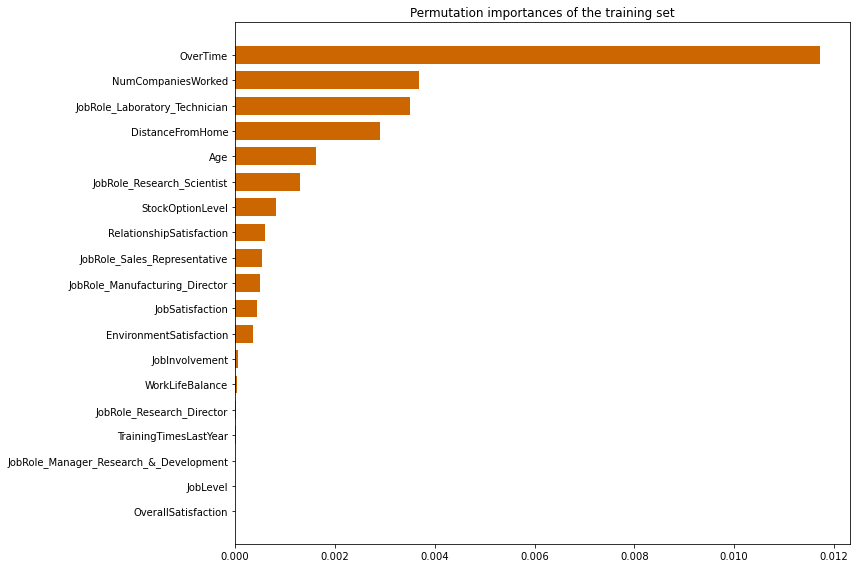



Predictions

Permutation importances of the test set

OverTime                                           0.085353
Age                                                0.035805
JobInvolvement                                     0.032088
JobRole_Sales_Representative                       0.023114
StockOptionLevel                                   0.022479
WorkLifeBalance                                    0.016101
DistanceFromHome                                   0.015763
JobLevel                                           0.011023
JobSatisfaction                                    0.008775
JobRole_Research_Scientist                         0.004462
JobRole_Research_Director                          0.003023
RelationshipSatisfaction                           0.000035
JobRole_Manager_Research_&_Development             -0.000184
EnvironmentSatisfaction                            -0.000874
OverallSatisfaction                                -0.003454
JobRole_Manufacturing_Director           

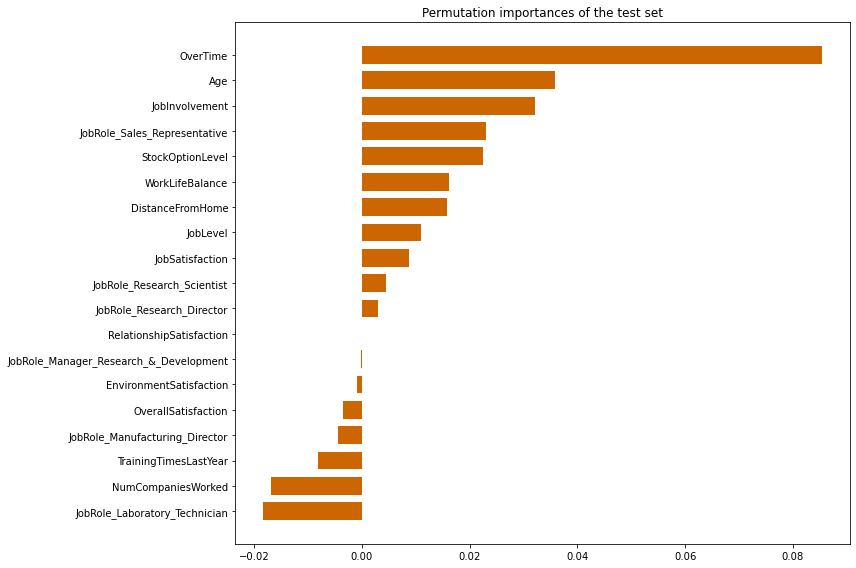



Confusion matrix


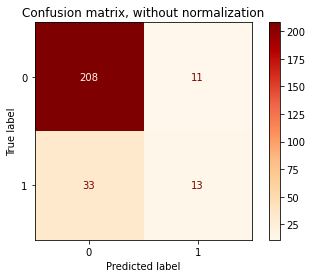

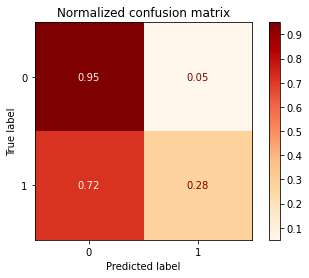


Classification report
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       219
           1       0.54      0.28      0.37        46

    accuracy                           0.83       265
   macro avg       0.70      0.62      0.64       265
weighted avg       0.81      0.83      0.81       265


Metrics

Accuracy 0.8339622641509434
F1-score [0.90434783 0.37142857]
Precision [0.86307054 0.54166667]
Recall [0.94977169 0.2826087 ]
Roc_auc 0.6161901925749453


Roc curve



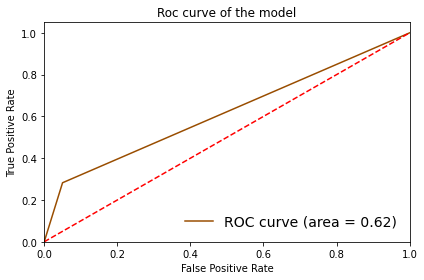


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6408546914125792
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


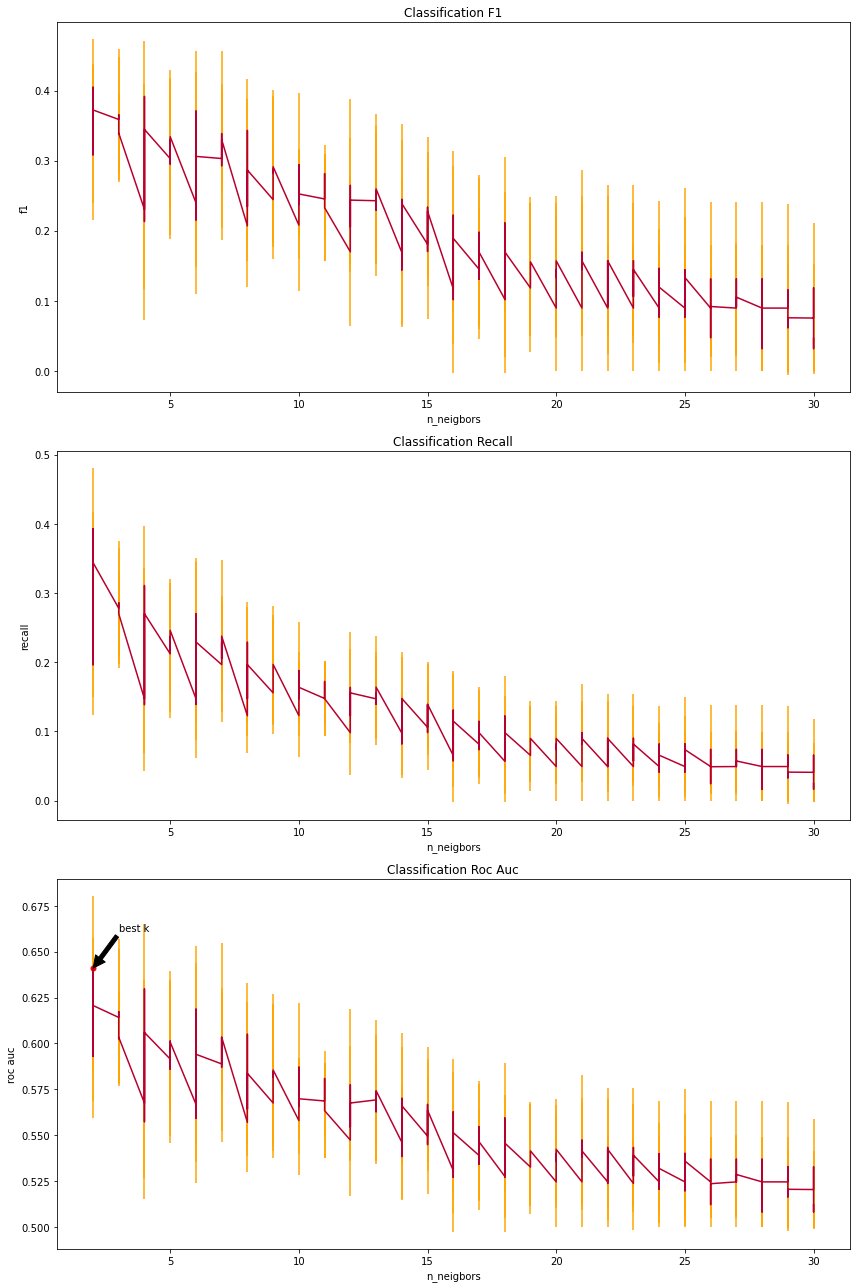



Permutation importances of the training set

NumCompaniesWorked                                 0.006179
DistanceFromHome                                   0.002283
OverTime                                           0.000703
JobRole_Research_Scientist                         0.000261
Age                                                0.000156
EnvironmentSatisfaction                            0.000093
JobRole_Laboratory_Technician                      0.000090
StockOptionLevel                                   0.000079
JobRole_Sales_Representative                       0.000079
JobSatisfaction                                    0.000010
RelationshipSatisfaction                           0.000006
TrainingTimesLastYear                              0.000004
JobInvolvement                                     0.000001
OverallSatisfaction                                0.000000
JobLevel                                           0.000000
JobRole_Manager_Research_&_Development             0.

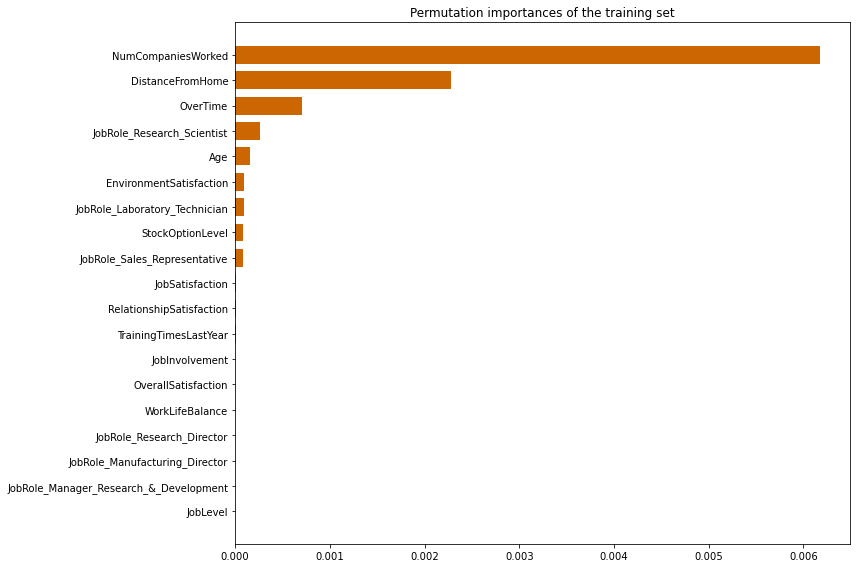



Predictions

Permutation importances of the test set

OverTime                                           0.074127
StockOptionLevel                                   0.060616
JobRole_Laboratory_Technician                      0.044675
Age                                                0.035130
JobSatisfaction                                    0.027066
OverallSatisfaction                                0.019996
NumCompaniesWorked                                 0.018162
JobRole_Sales_Representative                       0.015013
RelationshipSatisfaction                           0.011776
WorkLifeBalance                                    0.011014
JobInvolvement                                     0.010020
JobRole_Manufacturing_Director                     0.005711
DistanceFromHome                                   0.004905
JobRole_Research_Director                          0.004806
JobRole_Research_Scientist                         0.003601
JobRole_Manager_Research_&_Development      

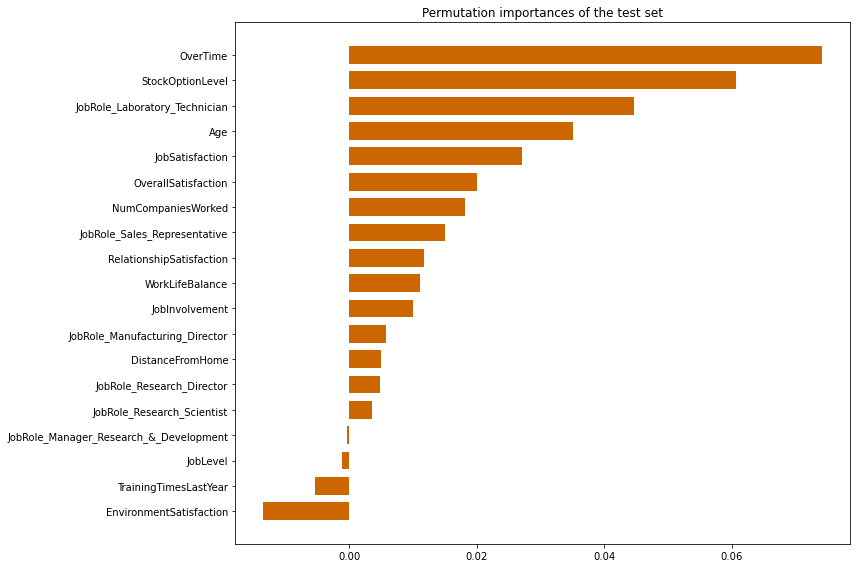



Confusion matrix


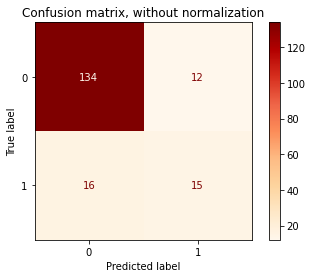

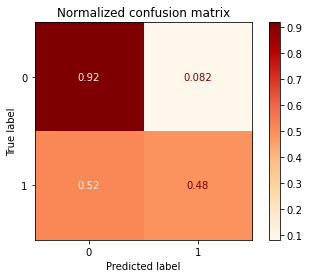


Classification report
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       146
           1       0.56      0.48      0.52        31

    accuracy                           0.84       177
   macro avg       0.72      0.70      0.71       177
weighted avg       0.83      0.84      0.84       177


Metrics

Accuracy 0.8418079096045198
F1-score [0.90540541 0.51724138]
Precision [0.89333333 0.55555556]
Recall [0.91780822 0.48387097]
Roc_auc 0.7008395934600088


Roc curve



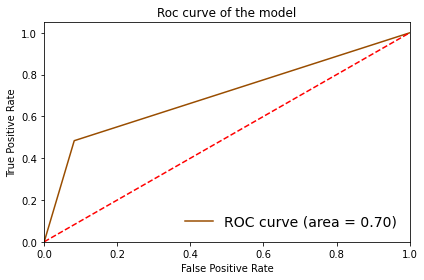


-------------------------------------------------------------------------------------------------------------



In [45]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
max_abs_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MaxAbsScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, max_abs_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = max_abs_dict

<h4>RobustScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.619557058418247
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


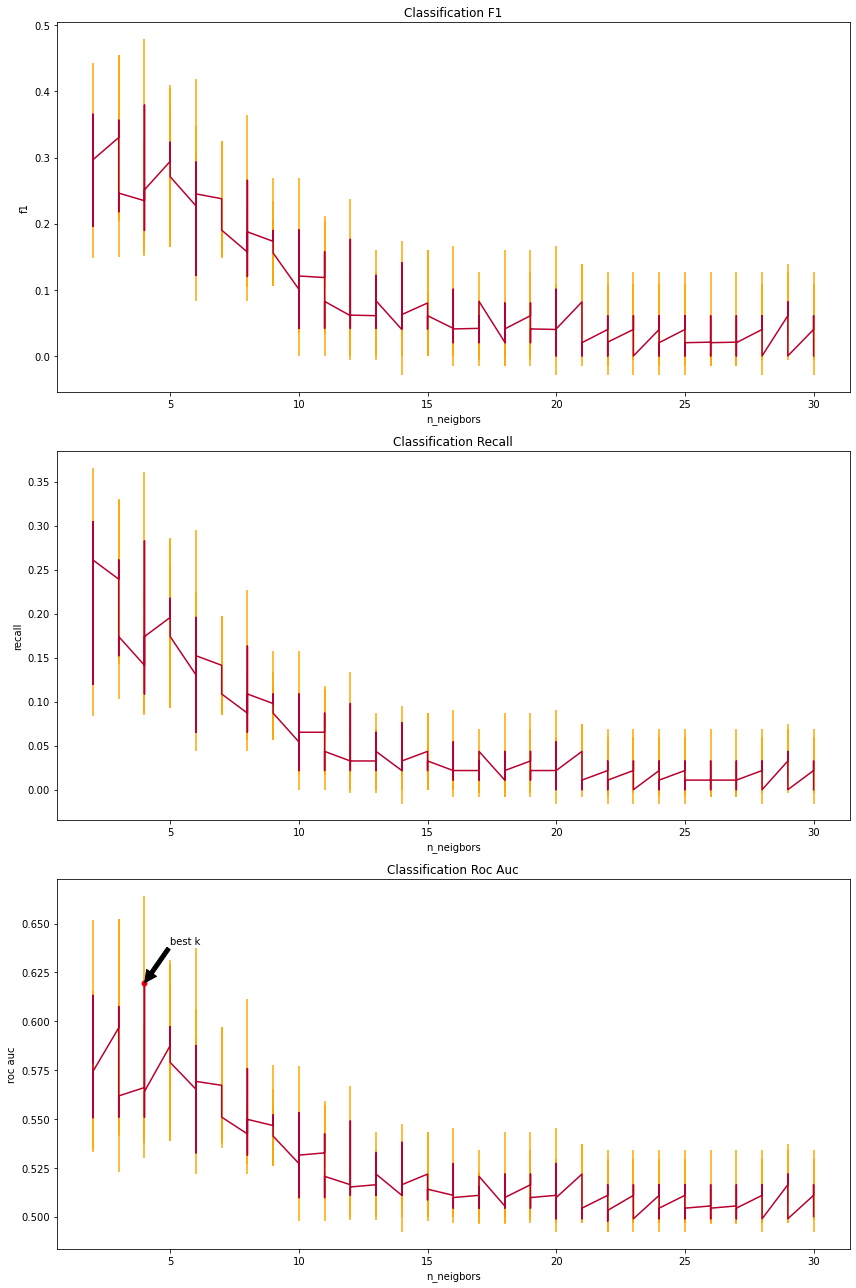



Permutation importances of the training set

StockOptionLevel                                   0.002554
TrainingTimesLastYear                              0.002240
WorkLifeBalance                                    0.000864
JobInvolvement                                     0.000852
JobLevel                                           0.000648
NumCompaniesWorked                                 0.000249
DistanceFromHome                                   0.000104
RelationshipSatisfaction                           0.000063
EnvironmentSatisfaction                            0.000062
OverallSatisfaction                                0.000035
JobSatisfaction                                    0.000030
Age                                                0.000025
OverTime                                           0.000010
JobRole_Laboratory_Technician                      0.000000
JobRole_Research_Scientist                         0.000000
JobRole_Manager_Research_&_Development             0.

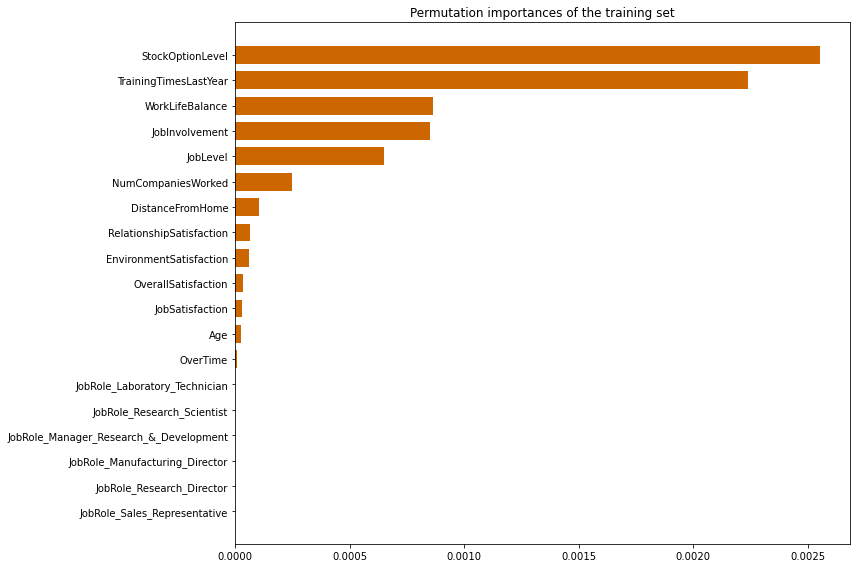



Predictions

Permutation importances of the test set

OverTime                                           0.041968
JobRole_Research_Scientist                         0.007299
JobRole_Sales_Representative                       0.003483
JobRole_Research_Director                          0.003027
StockOptionLevel                                   -0.000999
JobRole_Manufacturing_Director                     -0.001270
JobRole_Manager_Research_&_Development             -0.001444
JobInvolvement                                     -0.004848
NumCompaniesWorked                                 -0.010040
WorkLifeBalance                                    -0.016237
EnvironmentSatisfaction                            -0.016771
Age                                                -0.018444
JobSatisfaction                                    -0.018587
OverallSatisfaction                                -0.020718
JobLevel                                           -0.025424
DistanceFromHome                 

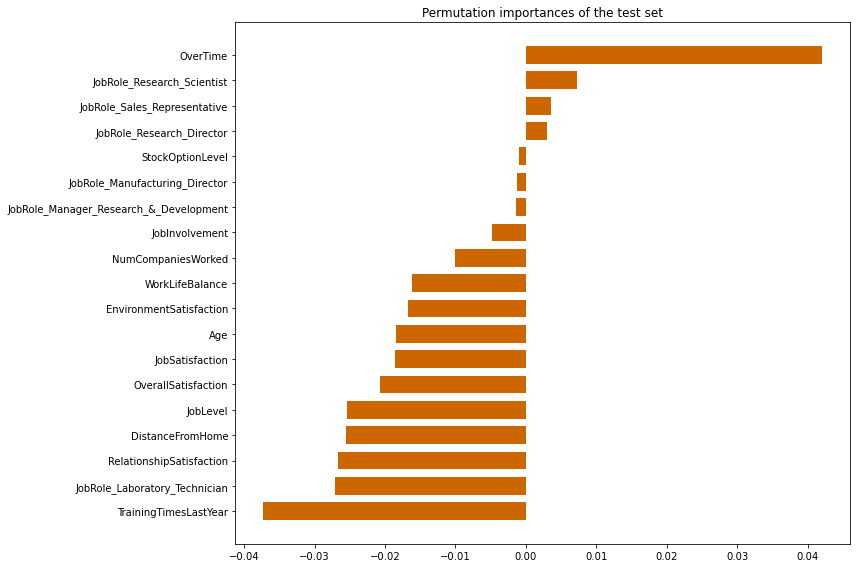



Confusion matrix


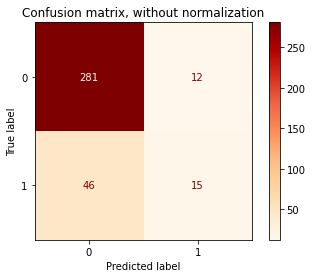

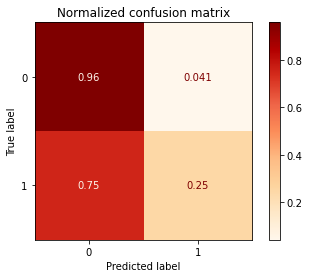


Classification report
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       293
           1       0.56      0.25      0.34        61

    accuracy                           0.84       354
   macro avg       0.71      0.60      0.62       354
weighted avg       0.81      0.84      0.81       354


Metrics

Accuracy 0.8361581920903954
F1-score [0.90645161 0.34090909]
Precision [0.85932722 0.55555556]
Recall [0.95904437 0.24590164]
Roc_auc 0.6024730039724725


Roc curve



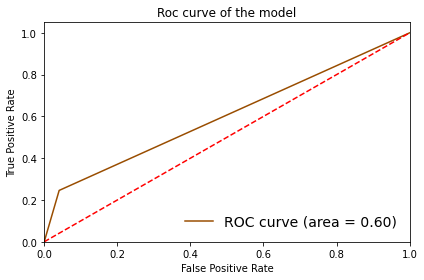


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5823692141897727
Best parameters: {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')

Best k ('n_neighbors'): 6

Plots of the metrics used by the grid search


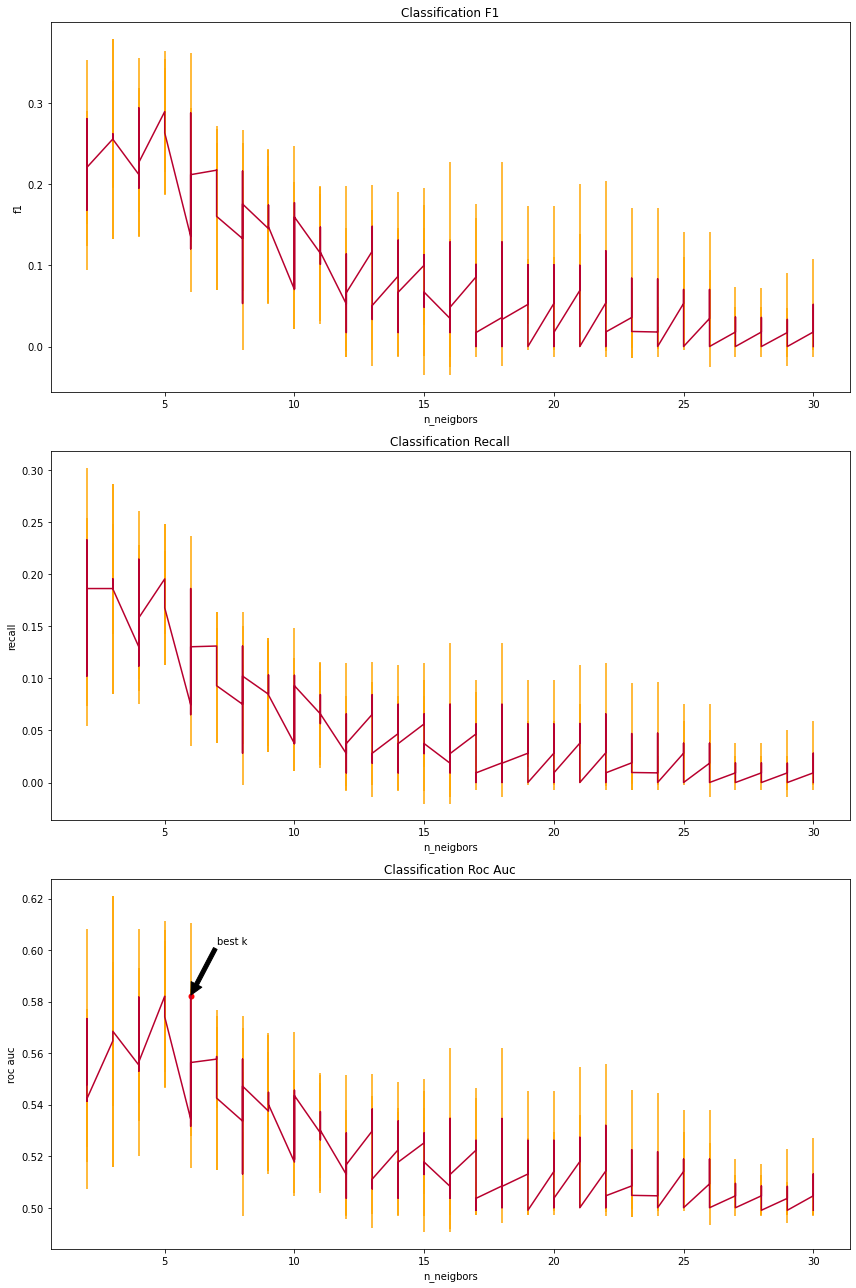



Permutation importances of the training set

StockOptionLevel                                   0.004678
TrainingTimesLastYear                              0.004201
JobLevel                                           0.002921
WorkLifeBalance                                    0.002001
JobInvolvement                                     0.001251
NumCompaniesWorked                                 0.000996
DistanceFromHome                                   0.000707
RelationshipSatisfaction                           0.000653
OverTime                                           0.000404
Age                                                0.000380
JobSatisfaction                                    0.000327
EnvironmentSatisfaction                            0.000194
OverallSatisfaction                                0.000068
JobRole_Laboratory_Technician                      0.000049
JobRole_Manufacturing_Director                     0.000015
JobRole_Research_Scientist                         0.

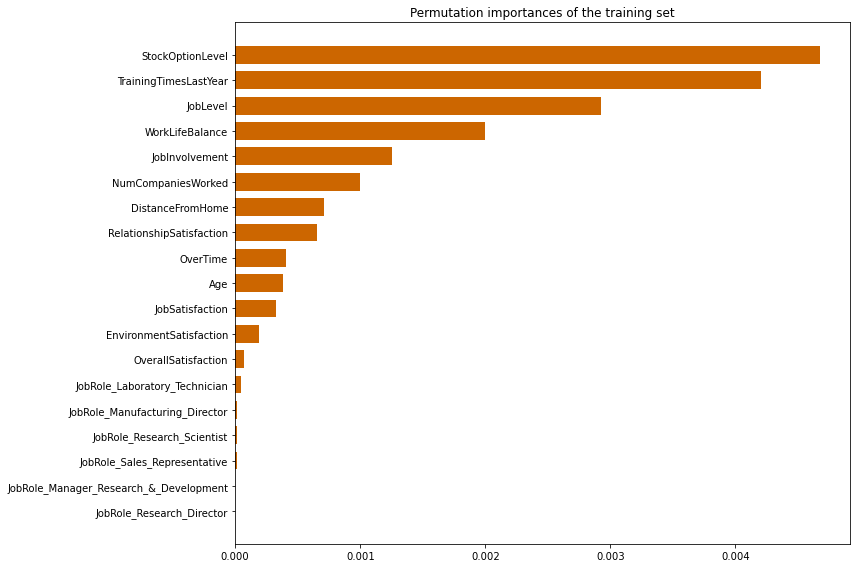



Predictions

Permutation importances of the test set

OverTime                                           0.042828
JobRole_Sales_Representative                       0.015044
StockOptionLevel                                   0.009252
JobInvolvement                                     0.008438
WorkLifeBalance                                    0.006785
NumCompaniesWorked                                 0.004933
JobLevel                                           0.002288
JobRole_Research_Director                          0.001807
JobRole_Manager_Research_&_Development             0.000581
EnvironmentSatisfaction                            0.000109
JobRole_Manufacturing_Director                     -0.000352
JobRole_Research_Scientist                         -0.011654
RelationshipSatisfaction                           -0.012239
DistanceFromHome                                   -0.013242
Age                                                -0.013272
JobSatisfaction                        

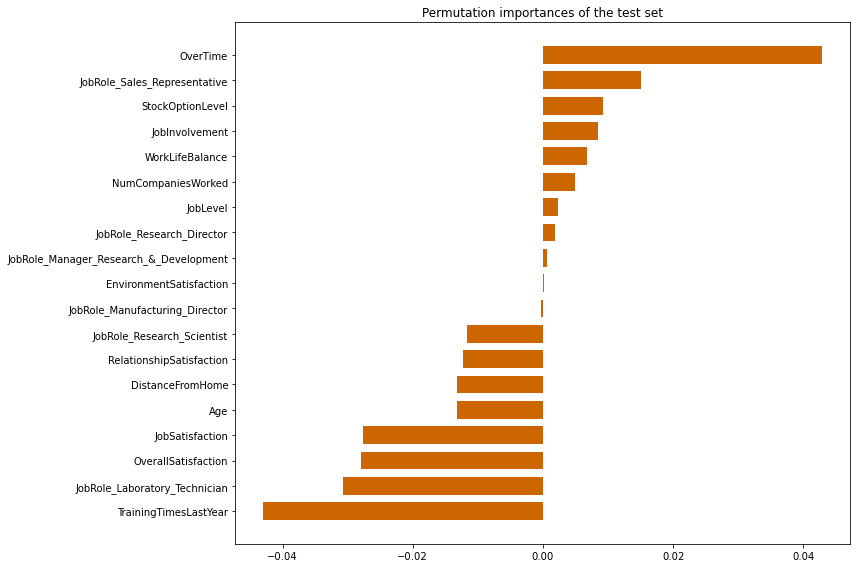



Confusion matrix


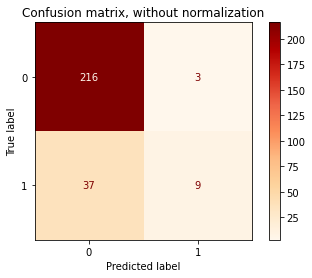

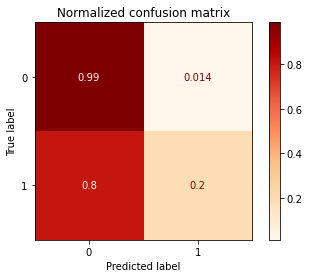


Classification report
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       219
           1       0.75      0.20      0.31        46

    accuracy                           0.85       265
   macro avg       0.80      0.59      0.61       265
weighted avg       0.84      0.85      0.81       265


Metrics

Accuracy 0.8490566037735849
F1-score [0.91525424 0.31034483]
Precision [0.85375494 0.75      ]
Recall [0.98630137 0.19565217]
Roc_auc 0.5909767718880286


Roc curve



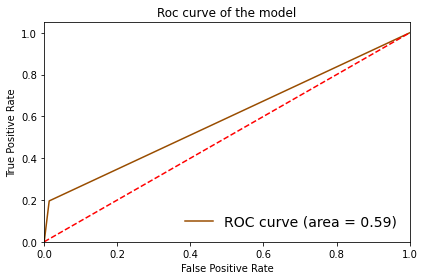


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6218552069524231
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


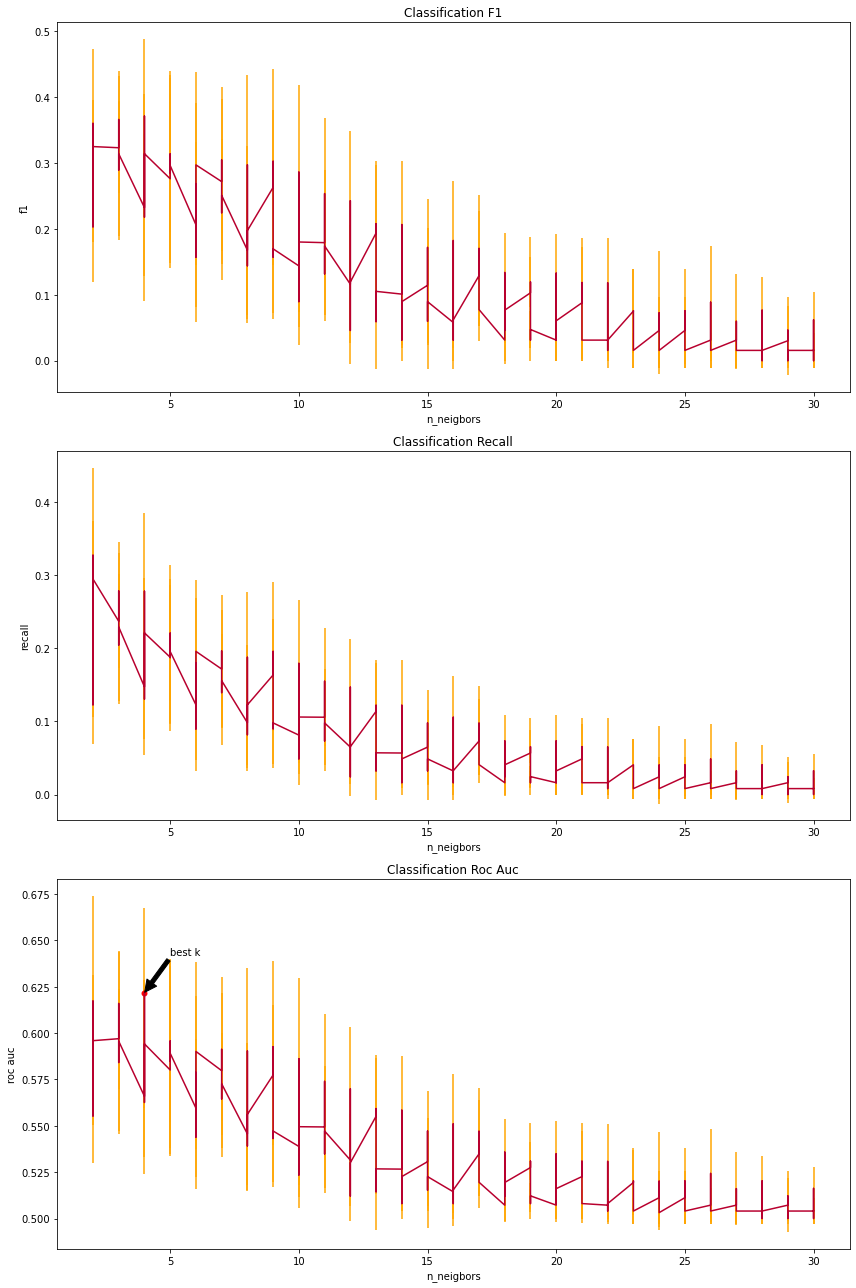



Permutation importances of the training set

StockOptionLevel                                   0.003174
TrainingTimesLastYear                              0.002807
WorkLifeBalance                                    0.001656
JobLevel                                           0.001213
JobInvolvement                                     0.000761
NumCompaniesWorked                                 0.000359
Age                                                0.000316
DistanceFromHome                                   0.000302
RelationshipSatisfaction                           0.000201
EnvironmentSatisfaction                            0.000083
JobSatisfaction                                    0.000066
OverallSatisfaction                                0.000027
OverTime                                           0.000007
JobRole_Sales_Representative                       0.000001
JobRole_Laboratory_Technician                      0.000000
JobRole_Research_Scientist                         0.

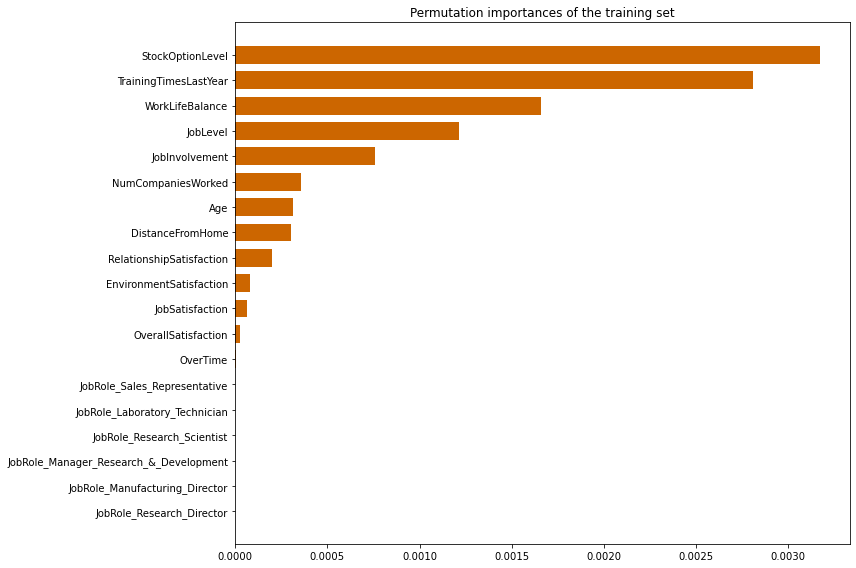



Predictions

Permutation importances of the test set

OverTime                                           0.051116
StockOptionLevel                                   0.026038
JobRole_Sales_Representative                       0.015433
JobLevel                                           0.013754
WorkLifeBalance                                    0.012981
JobRole_Research_Director                          0.003480
JobRole_Manufacturing_Director                     0.002364
JobRole_Laboratory_Technician                      0.001127
JobRole_Manager_Research_&_Development             0.000133
JobInvolvement                                     0.000122
NumCompaniesWorked                                 -0.000221
EnvironmentSatisfaction                            -0.000674
JobSatisfaction                                    -0.013886
DistanceFromHome                                   -0.014085
RelationshipSatisfaction                           -0.018526
TrainingTimesLastYear                  

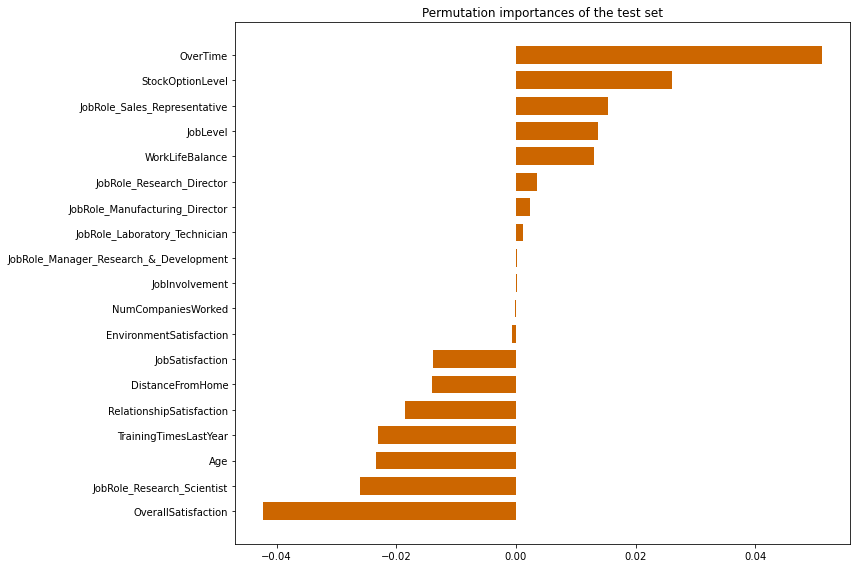



Confusion matrix


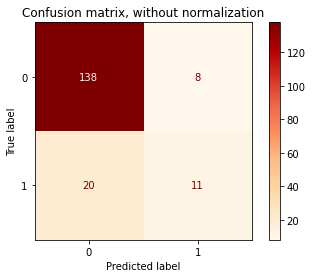

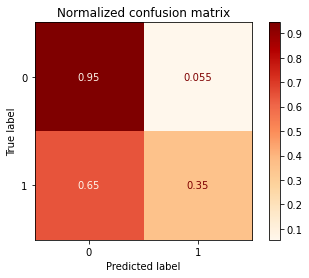


Classification report
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       146
           1       0.58      0.35      0.44        31

    accuracy                           0.84       177
   macro avg       0.73      0.65      0.67       177
weighted avg       0.82      0.84      0.83       177


Metrics

Accuracy 0.8418079096045198
F1-score [0.90789474 0.44      ]
Precision [0.87341772 0.57894737]
Recall [0.94520548 0.35483871]
Roc_auc 0.650022094564737


Roc curve



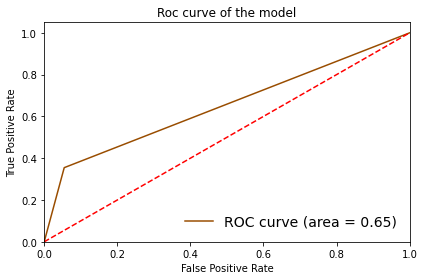


-------------------------------------------------------------------------------------------------------------



In [46]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
robust_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = RobustScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, robust_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = robust_dict

<h4>StandardScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6266789353446713
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


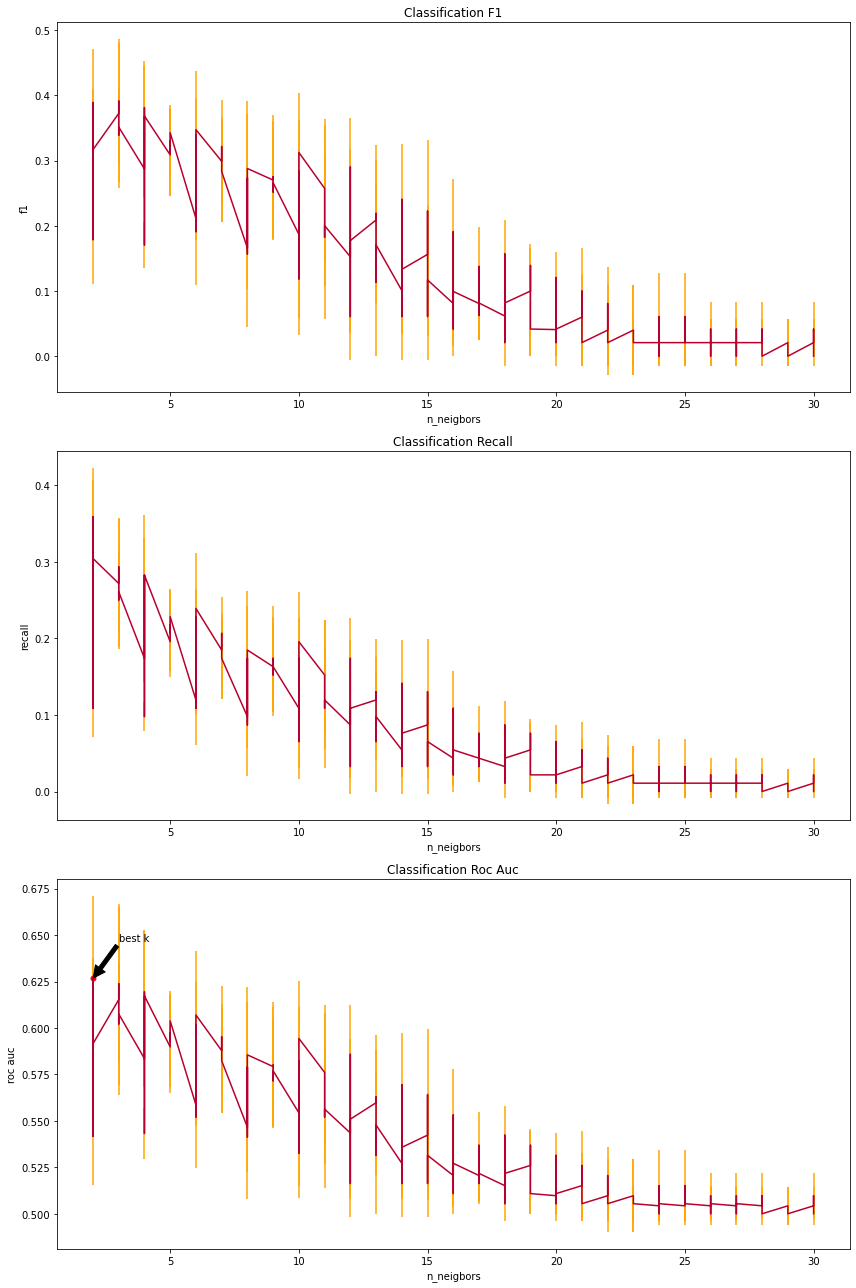



Permutation importances of the training set

JobInvolvement                                     0.000050
OverTime                                           0.000032
JobSatisfaction                                    0.000025
NumCompaniesWorked                                 0.000017
TrainingTimesLastYear                              0.000017
StockOptionLevel                                   0.000012
Age                                                0.000005
JobRole_Manager_Research_&_Development             0.000002
DistanceFromHome                                   0.000000
EnvironmentSatisfaction                            0.000000
JobLevel                                           0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manufacturing_Director                     0.000000
JobRole_Research_Director                          0.000000
JobRole_Research_Scientist                         0.000000
JobRole_Sales_Representative                       0.

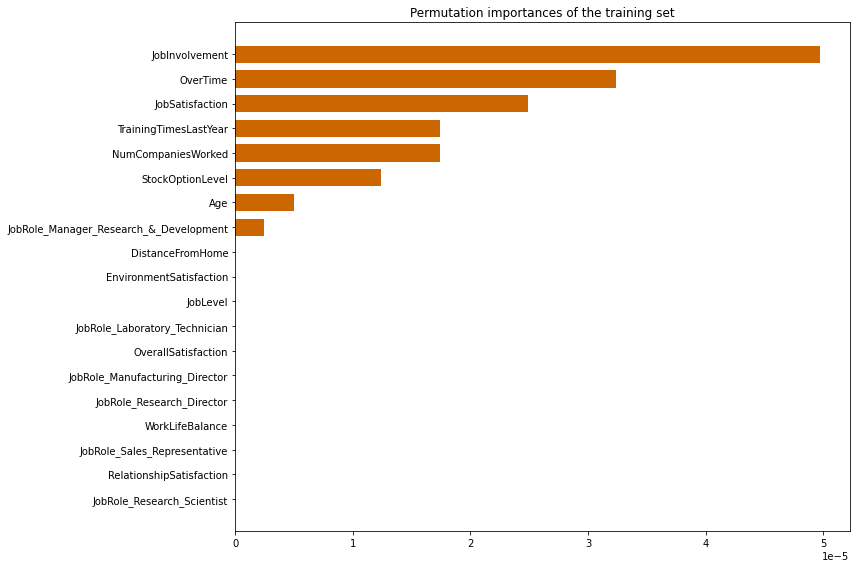



Predictions

Permutation importances of the test set

OverTime                                           0.052400
WorkLifeBalance                                    0.032088
EnvironmentSatisfaction                            0.028758
Age                                                0.022665
NumCompaniesWorked                                 0.021186
JobRole_Laboratory_Technician                      0.017938
JobSatisfaction                                    0.014256
JobInvolvement                                     0.014077
StockOptionLevel                                   0.012768
JobRole_Research_Director                          0.009920
DistanceFromHome                                   0.009447
JobLevel                                           0.006356
JobRole_Manager_Research_&_Development             0.000632
JobRole_Manufacturing_Director                     -0.000811
OverallSatisfaction                                -0.001723
JobRole_Research_Scientist                

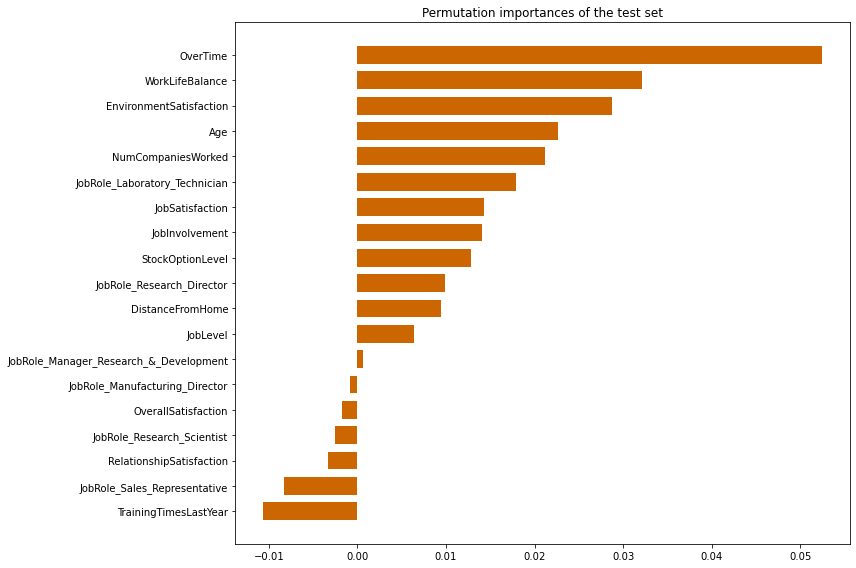



Confusion matrix


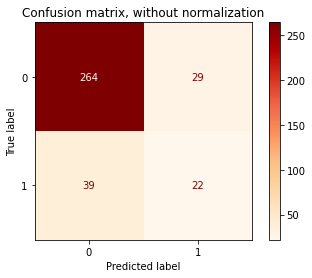

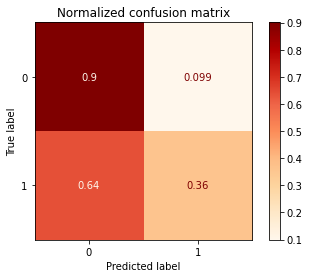


Classification report
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       293
           1       0.43      0.36      0.39        61

    accuracy                           0.81       354
   macro avg       0.65      0.63      0.64       354
weighted avg       0.80      0.81      0.80       354


Metrics

Accuracy 0.807909604519774
F1-score [0.88590604 0.39285714]
Precision [0.87128713 0.43137255]
Recall [0.90102389 0.36065574]
Roc_auc 0.6308398142449505


Roc curve



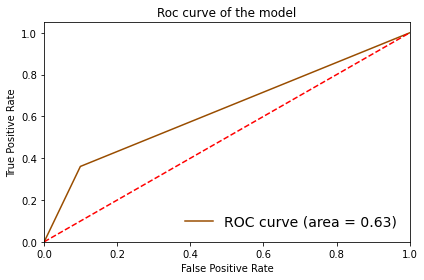


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.6116191418079951
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


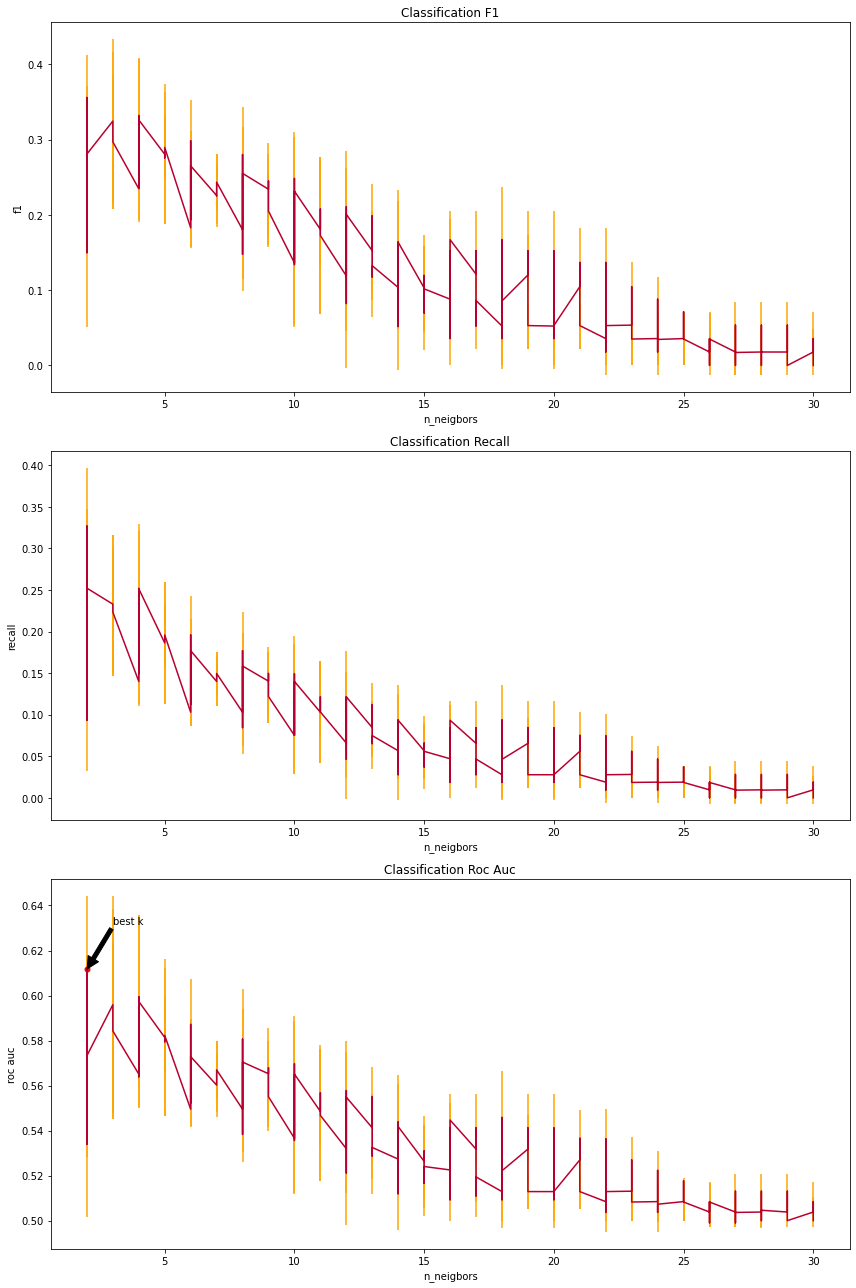



Permutation importances of the training set

JobInvolvement                                     0.000044
WorkLifeBalance                                    0.000042
NumCompaniesWorked                                 0.000037
TrainingTimesLastYear                              0.000029
OverTime                                           0.000016
JobRole_Sales_Representative                       0.000009
JobSatisfaction                                    0.000009
StockOptionLevel                                   0.000009
Age                                                0.000000
DistanceFromHome                                   0.000000
EnvironmentSatisfaction                            0.000000
JobLevel                                           0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.000000
JobRole_Research_Director                          0.

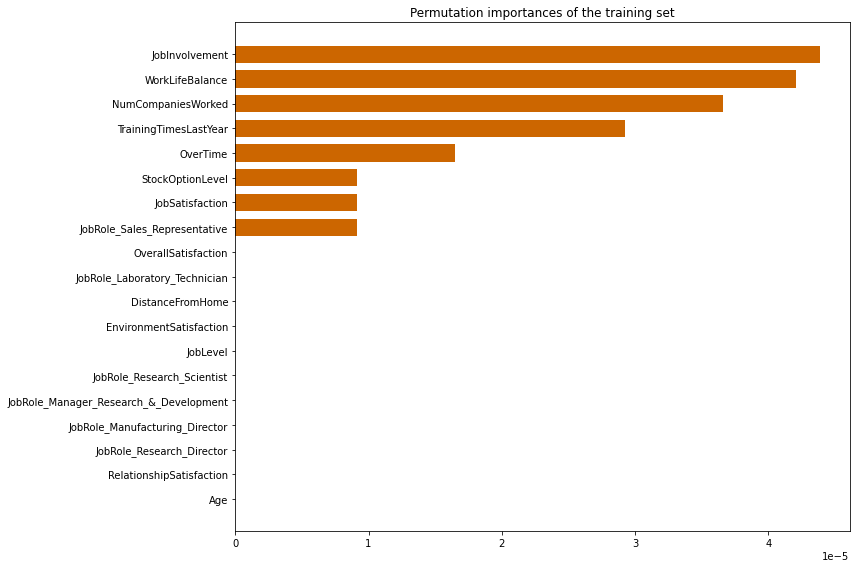



Predictions

Permutation importances of the test set

OverTime                                           0.060413
StockOptionLevel                                   0.050620
WorkLifeBalance                                    0.049181
DistanceFromHome                                   0.048571
JobInvolvement                                     0.043592
EnvironmentSatisfaction                            0.037359
JobSatisfaction                                    0.036257
Age                                                0.035602
NumCompaniesWorked                                 0.035592
JobLevel                                           0.027884
OverallSatisfaction                                0.024017
JobRole_Sales_Representative                       0.016875
JobRole_Laboratory_Technician                      0.016597
JobRole_Research_Scientist                         0.013848
TrainingTimesLastYear                              0.013689
RelationshipSatisfaction                    

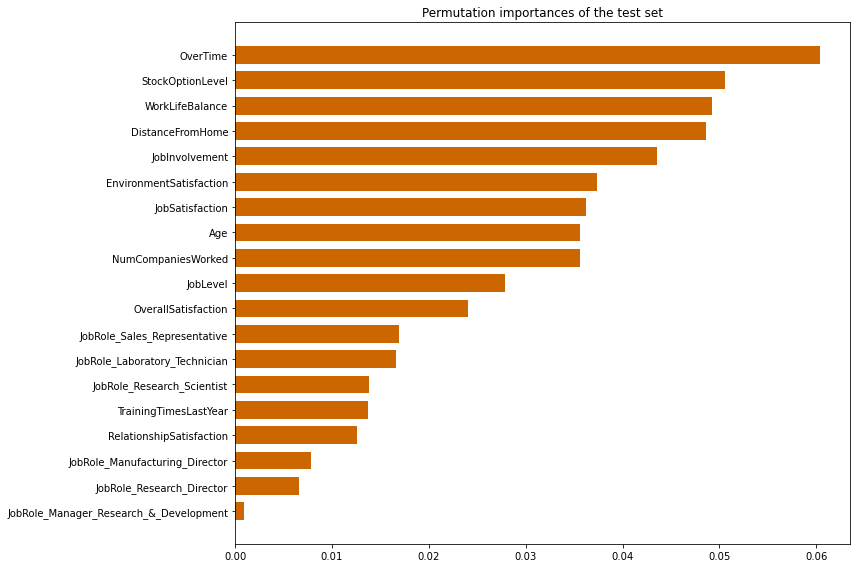



Confusion matrix


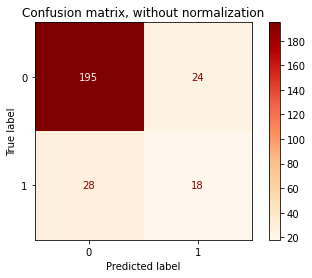

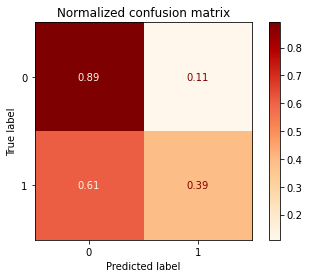


Classification report
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       219
           1       0.43      0.39      0.41        46

    accuracy                           0.80       265
   macro avg       0.65      0.64      0.65       265
weighted avg       0.80      0.80      0.80       265


Metrics

Accuracy 0.8037735849056604
F1-score [0.88235294 0.40909091]
Precision [0.87443946 0.42857143]
Recall [0.89041096 0.39130435]
Roc_auc 0.6408576533650983


Roc curve



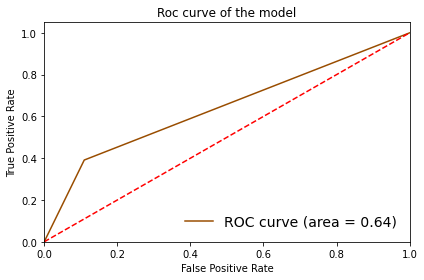


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6445279128001178
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


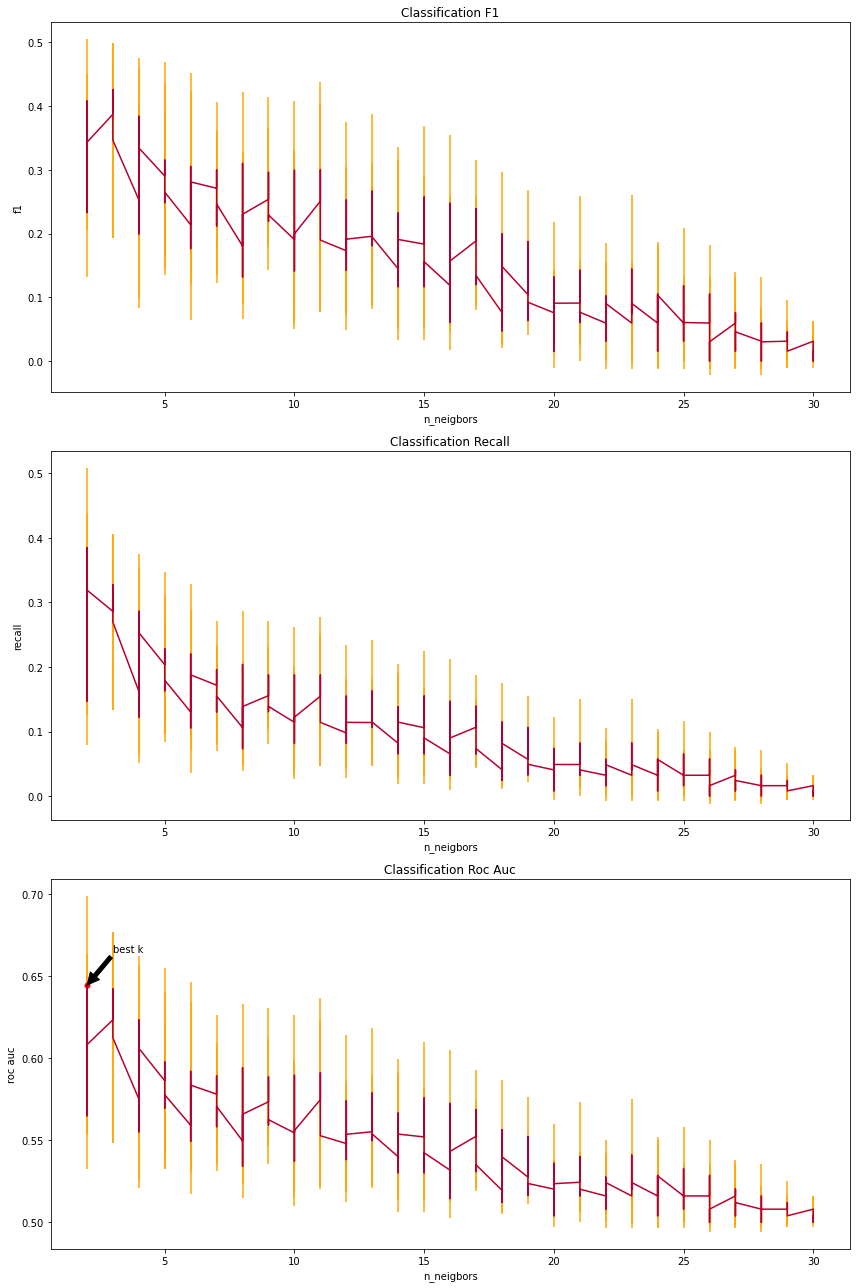



Permutation importances of the training set

JobRole_Sales_Representative                       0.000161
TrainingTimesLastYear                              0.000086
WorkLifeBalance                                    0.000036
JobInvolvement                                     0.000034
OverTime                                           0.000027
JobSatisfaction                                    0.000025
NumCompaniesWorked                                 0.000021
StockOptionLevel                                   0.000021
OverallSatisfaction                                0.000007
Age                                                0.000000
DistanceFromHome                                   0.000000
EnvironmentSatisfaction                            0.000000
JobLevel                                           0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.

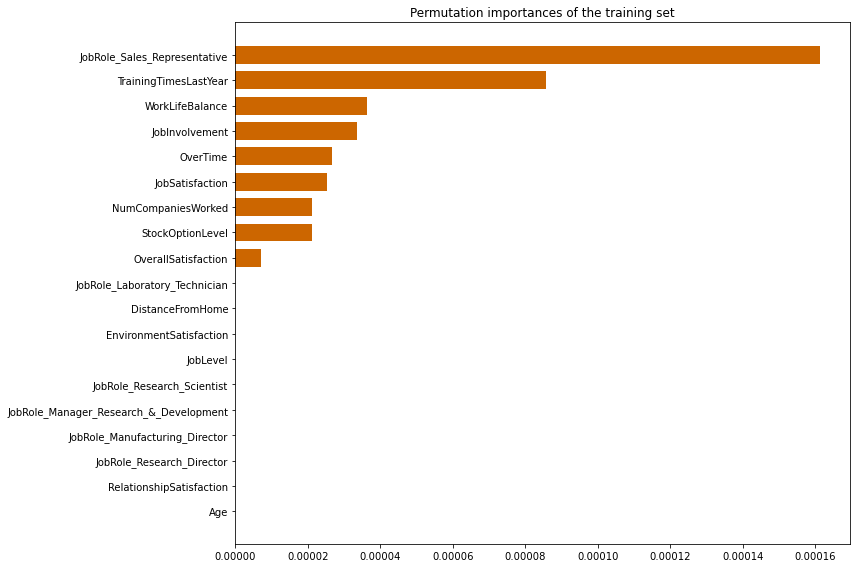



Predictions

Permutation importances of the test set

OverTime                                           0.059987
StockOptionLevel                                   0.051679
JobInvolvement                                     0.047978
NumCompaniesWorked                                 0.035009
WorkLifeBalance                                    0.032766
JobRole_Sales_Representative                       0.027486
JobRole_Laboratory_Technician                      0.025641
JobRole_Research_Scientist                         0.018814
JobRole_Research_Director                          0.016251
OverallSatisfaction                                0.015179
JobLevel                                           0.014892
Age                                                0.013146
JobRole_Manufacturing_Director                     0.011898
TrainingTimesLastYear                              0.009976
JobSatisfaction                                    0.006021
JobRole_Manager_Research_&_Development      

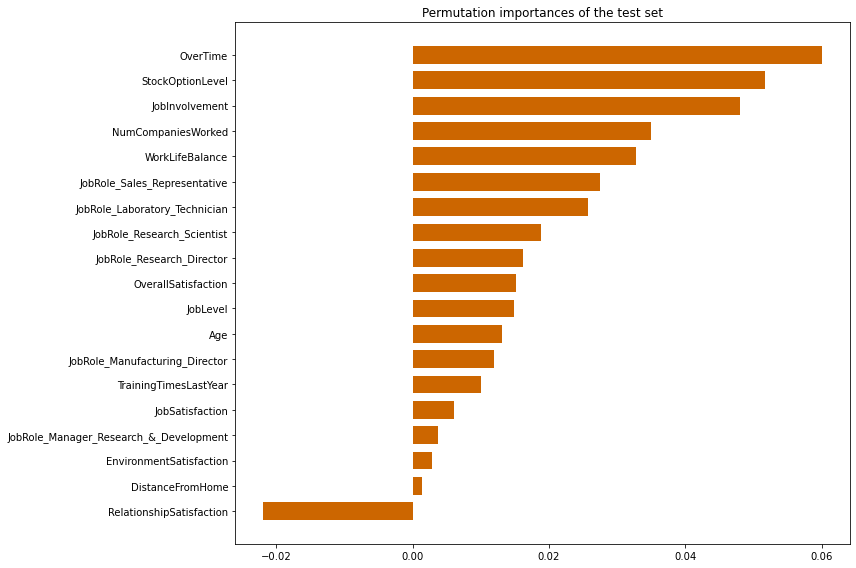



Confusion matrix


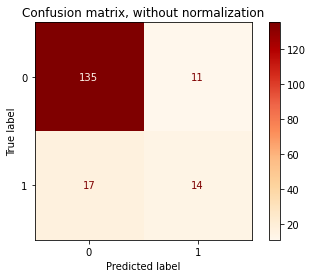

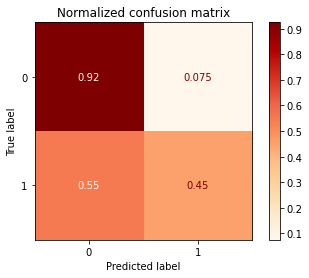


Classification report
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       146
           1       0.56      0.45      0.50        31

    accuracy                           0.84       177
   macro avg       0.72      0.69      0.70       177
weighted avg       0.83      0.84      0.83       177


Metrics

Accuracy 0.8418079096045198
F1-score [0.90604027 0.5       ]
Precision [0.88815789 0.56      ]
Recall [0.92465753 0.4516129 ]
Roc_auc 0.6881352187361909


Roc curve



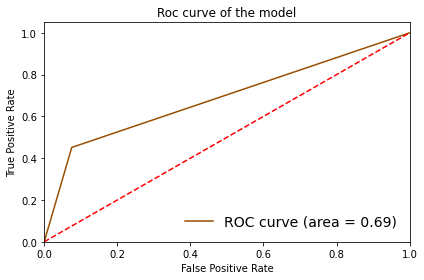


-------------------------------------------------------------------------------------------------------------



In [47]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
standard_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = StandardScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, standard_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = standard_dict

In [48]:
scaler_dict

{'MinMaxScaler': {'60-40': {'fpr': [0.0, 0.10238907849829351, 1.0],
   'tpr': [0.0, 0.3770491803278688, 1.0],
   'roc': 0.6373300509147877},
  '70-30': {'fpr': [0.0, 0.0365296803652968, 1.0],
   'tpr': [0.0, 0.2826086956521739, 1.0],
   'roc': 0.6230395076434385},
  '80-20': {'fpr': [0.0, 0.07534246575342465, 1.0],
   'tpr': [0.0, 0.45161290322580644, 1.0],
   'roc': 0.6881352187361909}},
 'MaxAbsScaler': {'60-40': {'fpr': [0.0, 0.10921501706484642, 1.0],
   'tpr': [0.0, 0.29508196721311475, 1.0],
   'roc': 0.5929334750741342},
  '70-30': {'fpr': [0.0, 0.0502283105022831, 1.0],
   'tpr': [0.0, 0.2826086956521739, 1.0],
   'roc': 0.6161901925749453},
  '80-20': {'fpr': [0.0, 0.0821917808219178, 1.0],
   'tpr': [0.0, 0.4838709677419355, 1.0],
   'roc': 0.7008395934600088}},
 'RobustScaler': {'60-40': {'fpr': [0.0, 0.040955631399317405, 1.0],
   'tpr': [0.0, 0.2459016393442623, 1.0],
   'roc': 0.6024730039724725},
  '70-30': {'fpr': [0.0, 0.0136986301369863, 1.0],
   'tpr': [0.0, 0.195652

In [66]:
temporal_info = {}

In [67]:
model_name = '20f onehot-encoded quantile discretized'

In [68]:
temporal_info[model_name] = scaler_dict['MaxAbsScaler']['80-20']
temporal_info

{'20f onehot-encoded quantile discretized': {'fpr': [0.0,
   0.0821917808219178,
   1.0],
  'tpr': [0.0, 0.4838709677419355, 1.0],
  'roc': 0.7008395934600088}}

In [69]:
with open('temporal_info.json', "r+") as json_file: 
    data = json.load(json_file)
    data['qcut']['validation'].update(temporal_info)

    
with open('temporal_info.json','w') as f: 
    json.dump(data, f, indent=4)